
# ADV Data Cleaning Assignment

In this notebook, we will clean the ADV data using object-oriented programming techniques. We will visualize the data, identify outliers, and apply filtering to remove noisy data points.

The dataset being used is a 14-minute sample of ADV data collected in the South San Francisco Bay in July 2018. The goal is to clean this data using the following techniques:
- Time-series plot and histogram visualization
- Outlier identification using thresholding
- Signal filtering and comparison

Let's start by defining a class to load and handle the data.


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)

    def plot_time_series(self):
        """Method to plot the time-series of the velocity."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Velocity (U)", color="blue")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Time Series Plot of Water Velocity')
        plt.legend()
        plt.show()

    def plot_histogram(self):
        """Method to plot a histogram of the velocity."""
        plt.figure(figsize=(8, 5))
        plt.hist(self.u, bins=30, edgecolor='black', color="skyblue")
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Frequency')
        plt.title('Histogram of Water Velocity')
        plt.show()

    def apply_threshold(self, threshold):
        """Method to apply a threshold and filter out 'bad' data."""
        self.u_filtered_simple = np.where(self.u > threshold, np.nan, self.u)
        nan_percentage = np.isnan(self.u_filtered_simple).mean() * 100
        print(f'{nan_percentage:.2f}% of the data set to NaN')

    def plot_filtered_signal(self):
        """Method to plot the original signal vs the filtered signal."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Original Signal", color="blue")
        plt.plot(self.t, self.u_filtered_simple, label="Filtered Signal", color="red", linestyle='--')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs. Filtered Signal')
        plt.legend()
        plt.show()


In [4]:

# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')


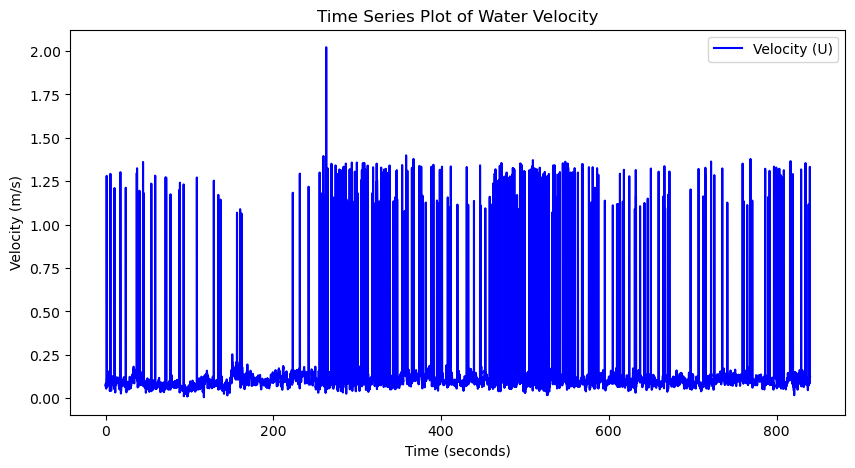

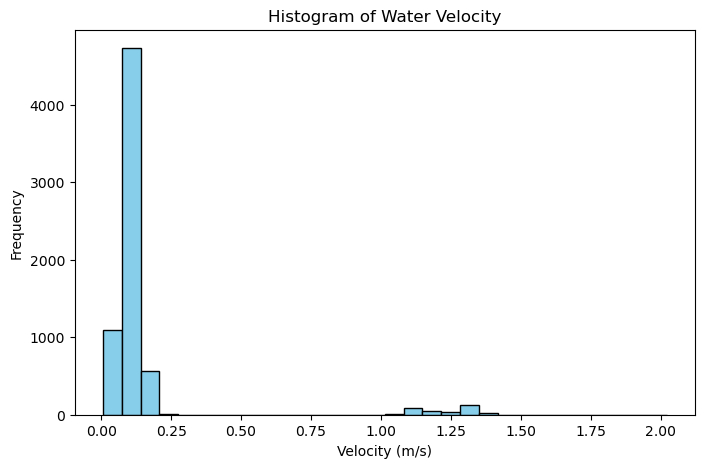

In [5]:

# Plot the time series of the velocity
adv_data.plot_time_series()

# Plot the histogram of the velocity
adv_data.plot_histogram()


4.96% of the data set to NaN


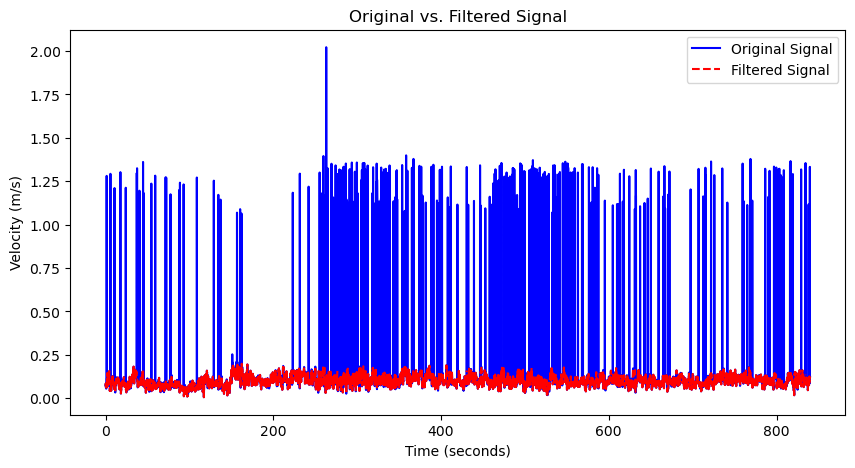

In [6]:

# Apply a threshold to filter out velocities greater than 0.2 m/s
adv_data.apply_threshold(0.2)

# Plot the original signal and filtered signal
adv_data.plot_filtered_signal()


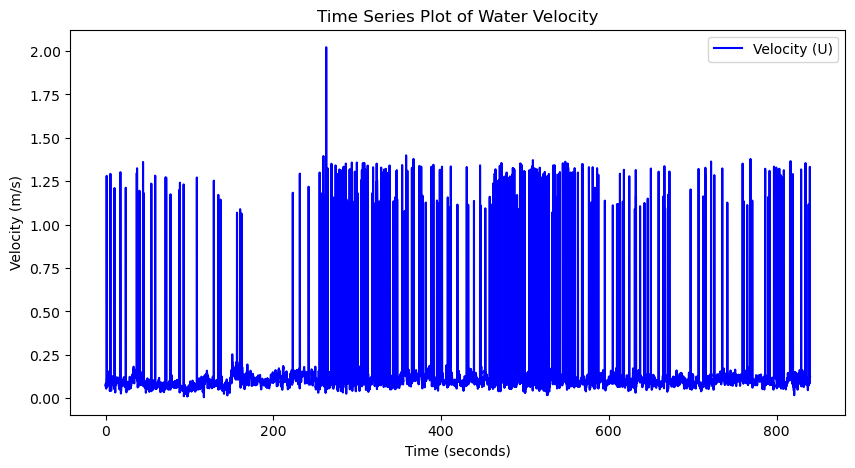

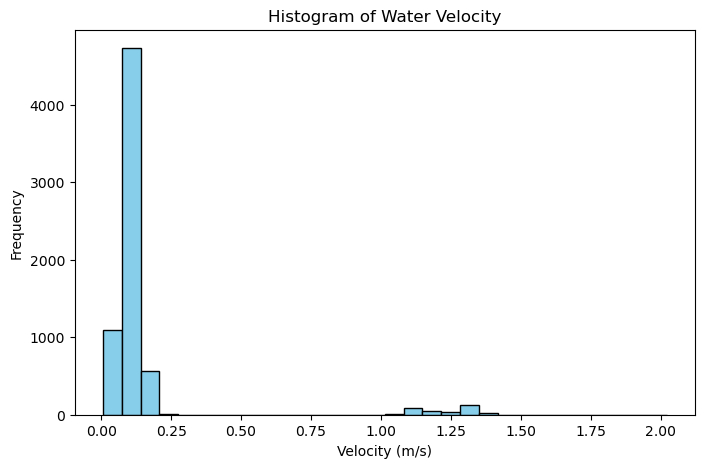

C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_6020\3739074477.py:57: RuntimeWarning: invalid value encountered in sqrt
  self.a2 = np.sqrt(a2_squared)
C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_6020\3739074477.py:58: RuntimeWarning: invalid value encountered in sqrt
  self.b2 = np.sqrt(b2_squared)


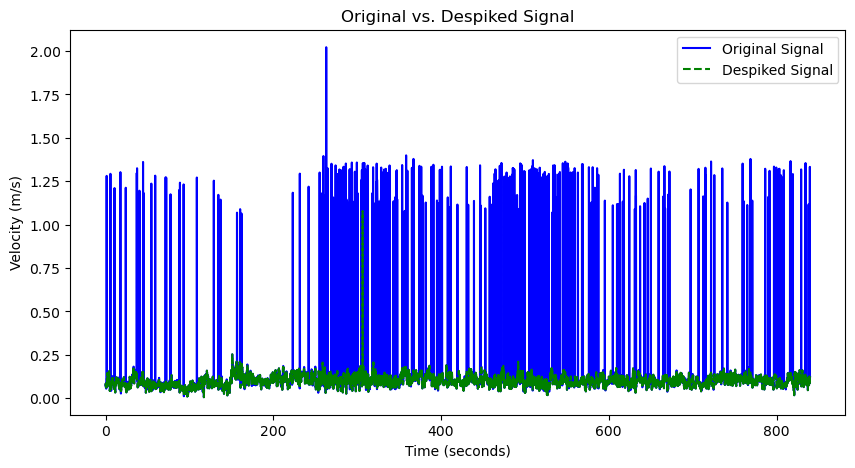

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)
        
        # Calculate standard deviations
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)
        
        # Universal maximum scaling factor λ
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def plot_time_series(self):
        """Method to plot the time-series of the velocity."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Velocity (U)", color="blue")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Time Series Plot of Water Velocity')
        plt.legend()
        plt.show()

    def plot_histogram(self):
        """Method to plot a histogram of the velocity."""
        plt.figure(figsize=(8, 5))
        plt.hist(self.u, bins=30, edgecolor='black', color="skyblue")
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Frequency')
        plt.title('Histogram of Water Velocity')
        plt.show()

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        # u-Δu ellipse
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        # u-Δ²u ellipse: solve for a2 and b2
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle θ for the u-Δ²u ellipse
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        # Δu-Δ²u ellipse
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        # Check for bad indices for u-Δ²u ellipse
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        # Check for bad indices for Δu-Δ²u ellipse
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u_filtered_despiked[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_filtered_signal(self):
        """Method to plot the original signal vs the despiked signal."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Original Signal", color="blue")
        plt.plot(self.t, self.u_filtered_despiked, label="Despiked Signal", color="green", linestyle='--')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs. Despiked Signal')
        plt.legend()
        plt.show()

# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Plot the time series of the velocity
adv_data.plot_time_series()

# Plot the histogram of the velocity
adv_data.plot_histogram()

# Calculate ellipse axes
adv_data.calculate_ellipse_axes()

# Find bad indices based on ellipses
adv_data.find_bad_indices()

# Apply despiking and impute NaN values
adv_data.apply_despiking()

# Plot the original signal and despiked signal
adv_data.plot_filtered_signal()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)
        
        # Calculate standard deviations
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)
        
        # Universal maximum scaling factor λ
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def plot_time_series(self):
        """Method to plot the time-series of the velocity."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Velocity (U)", color="blue")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Time Series Plot of Water Velocity')
        plt.legend()
        plt.show()

    def plot_histogram(self):
        """Method to plot a histogram of the velocity."""
        plt.figure(figsize=(8, 5))
        plt.hist(self.u, bins=30, edgecolor='black', color="skyblue")
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Frequency')
        plt.title('Histogram of Water Velocity')
        plt.show()

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        # u-Δ²u ellipse: solve for a2 and b2
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle θ for the u-Δ²u ellipse
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u_filtered_despiked[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_filtered_signal(self):
        """Method to plot the original signal vs the despiked signal."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Original Signal", color="blue")
        plt.plot(self.t, self.u_filtered_despiked, label="Despiked Signal", color="green", linestyle='--')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs. Despiked Signal')
        plt.legend()
        plt.show()


In [5]:
adv_data = AdvData('adv.csv')

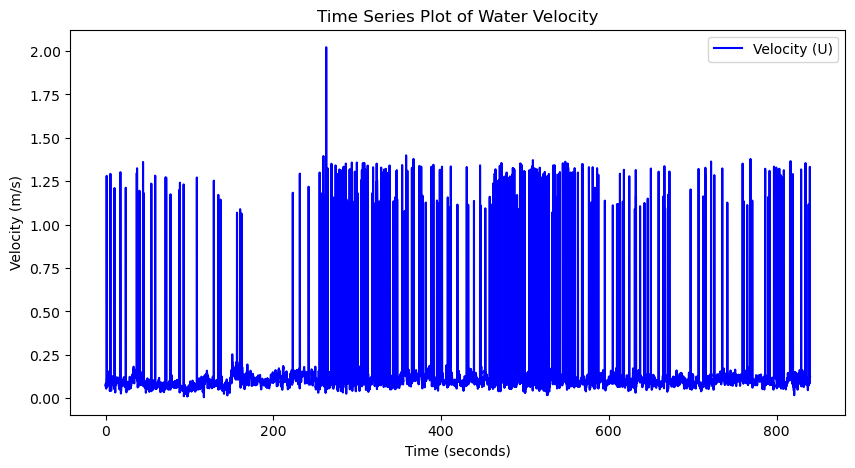

In [6]:
adv_data.plot_time_series()


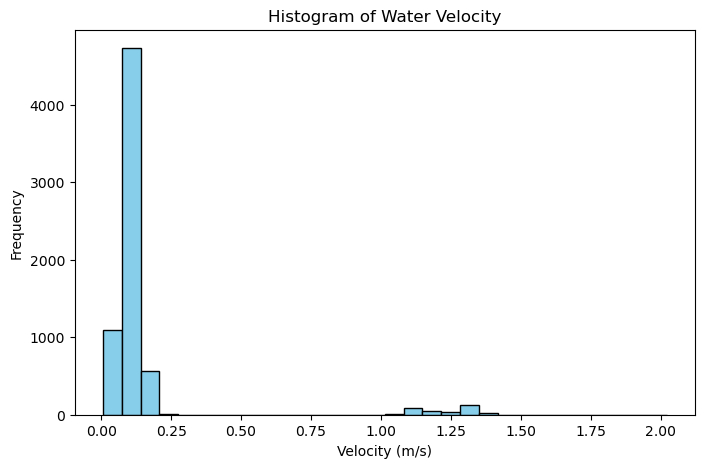

In [7]:
adv_data.plot_histogram()

In [8]:
adv_data.calculate_ellipse_axes()

C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9184\2466276432.py:56: RuntimeWarning: invalid value encountered in sqrt
  self.a2 = np.sqrt(a2_squared)
C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9184\2466276432.py:57: RuntimeWarning: invalid value encountered in sqrt
  self.b2 = np.sqrt(b2_squared)


In [9]:
adv_data.find_bad_indices()

In [10]:
adv_data.apply_despiking()

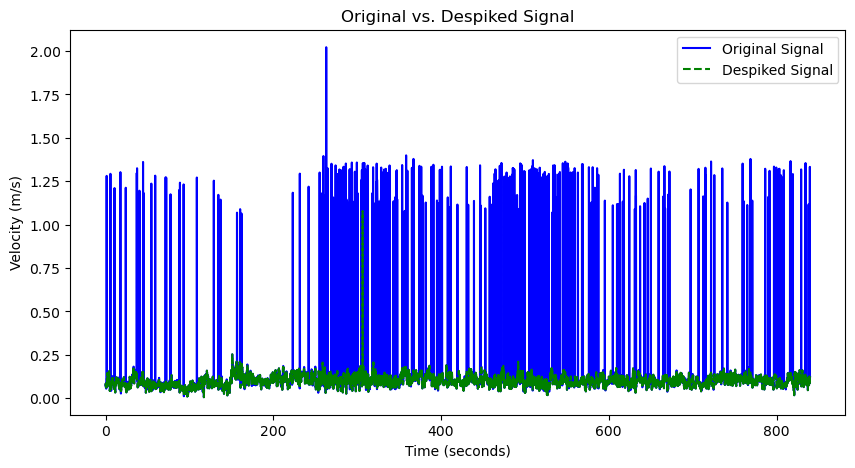

In [11]:
adv_data.plot_filtered_signal()

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)
        
        # Calculate standard deviations
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)
        
        # Universal maximum scaling factor λ
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle θ for the u-Δ²u ellipse
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u_filtered_despiked[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses."""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.u, self.dU, label='Data Points', color='blue')
        plt.scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        
        # Plot the u-Δu ellipse (unrotated, θ = 0)
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        plt.plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        
        plt.xlabel('u (Velocity)')
        plt.ylabel('Δu (First Derivative)')
        plt.title(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")


C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9184\652231628.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.a2 = np.sqrt(a2_squared)
C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9184\652231628.py:37: RuntimeWarning: invalid value encountered in sqrt
  self.b2 = np.sqrt(b2_squared)


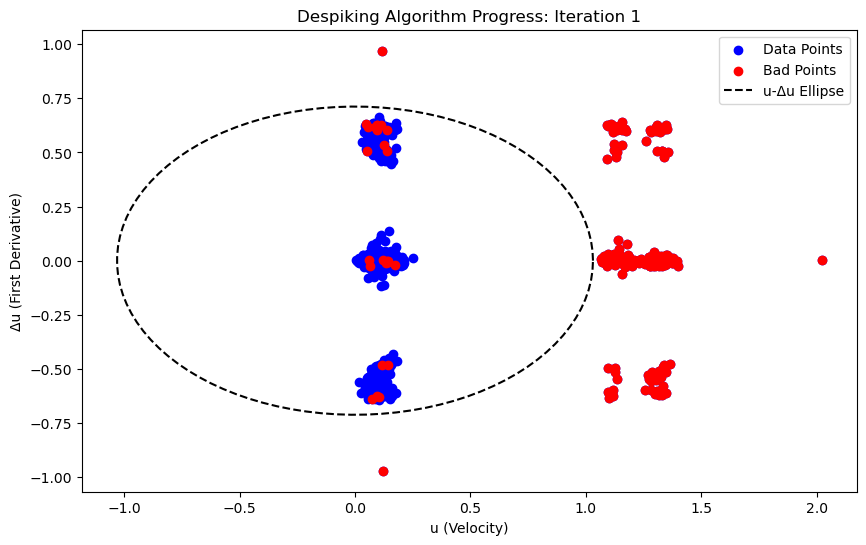

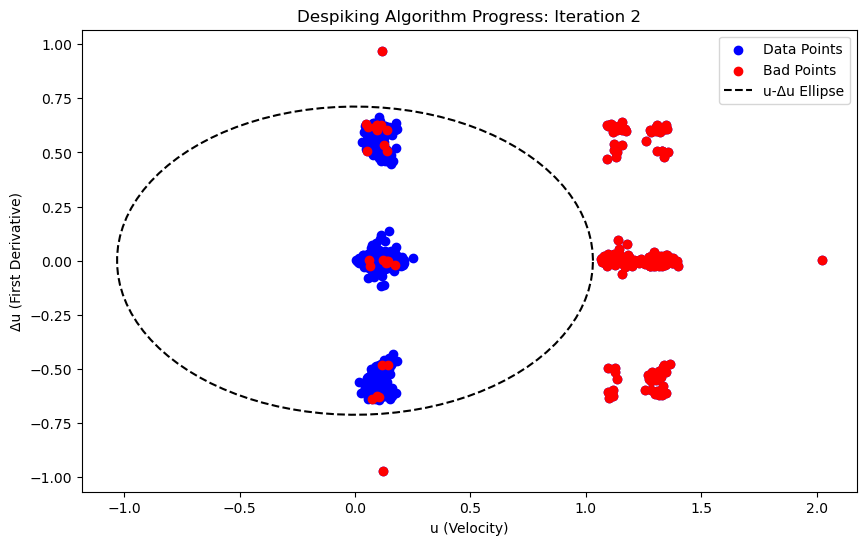

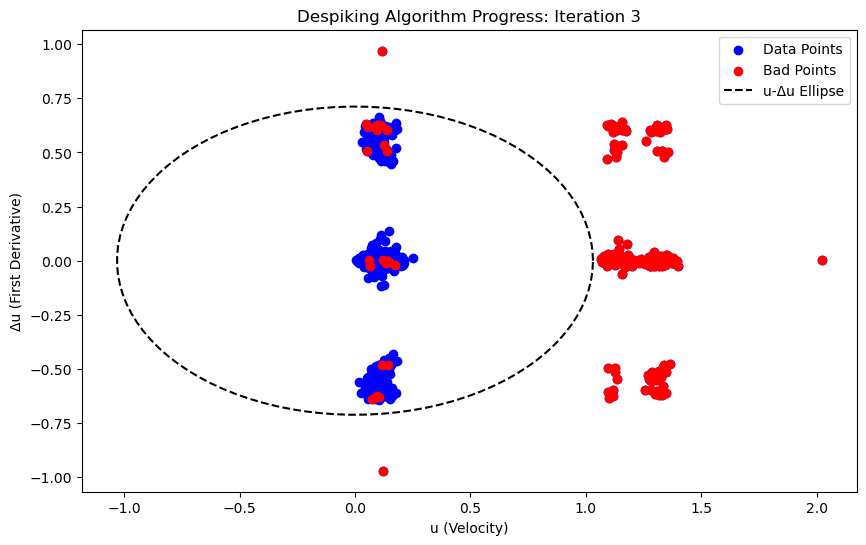

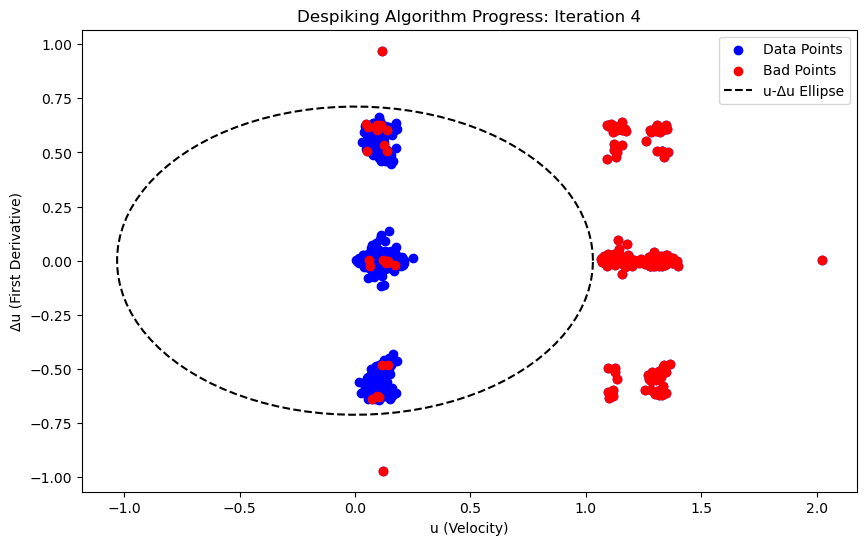

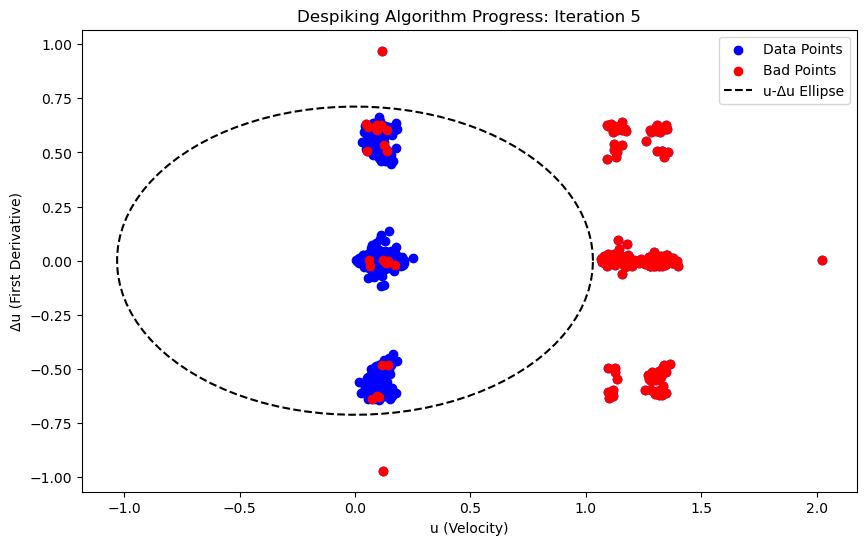

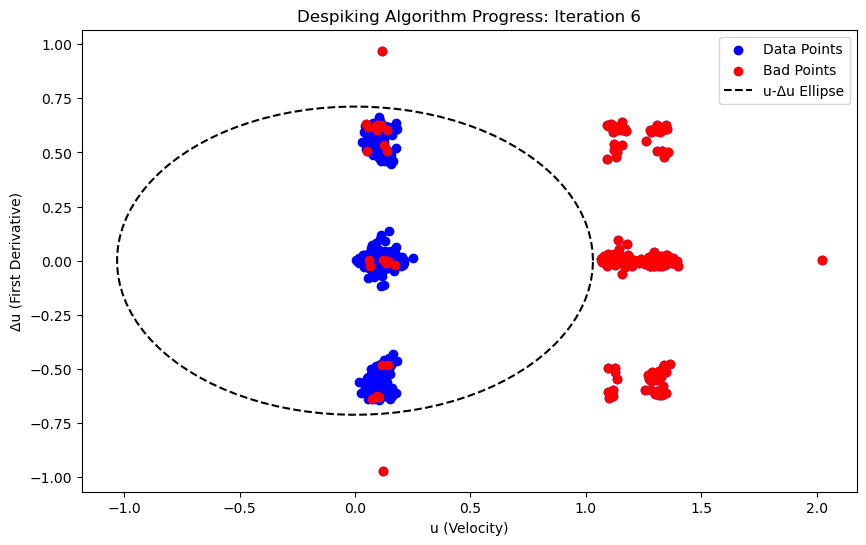

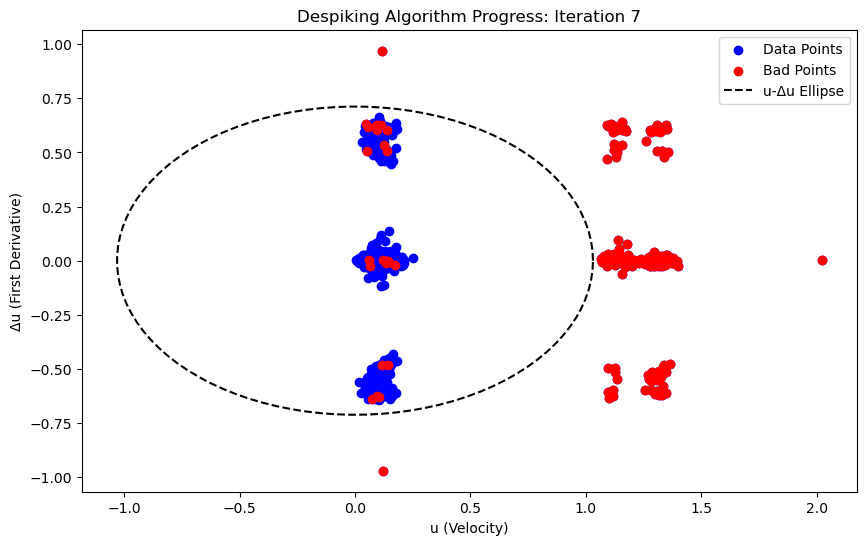

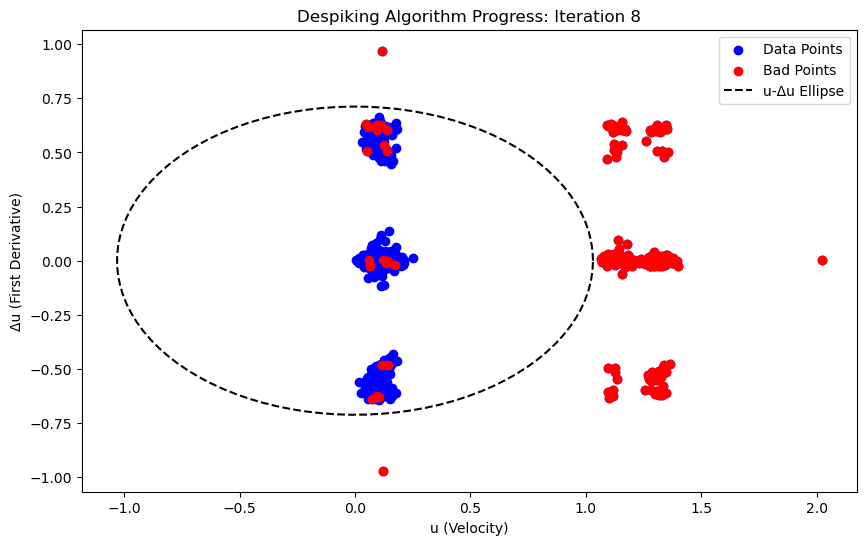

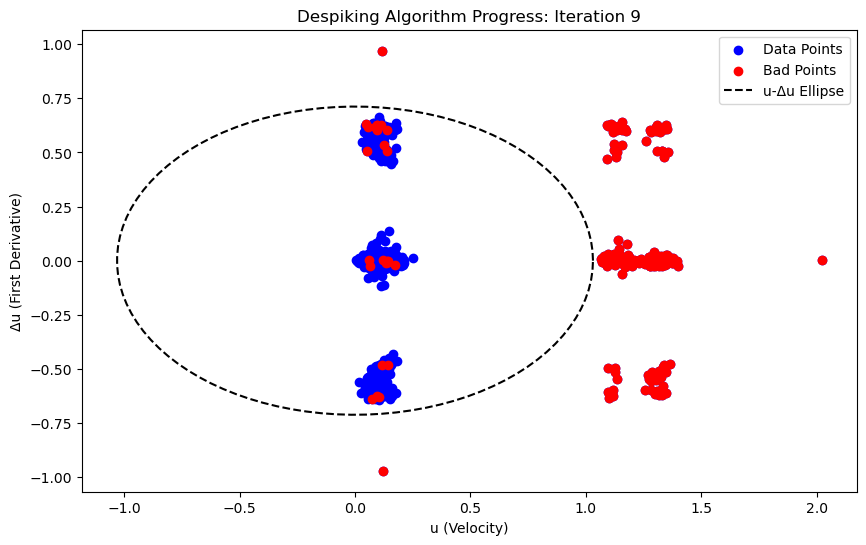

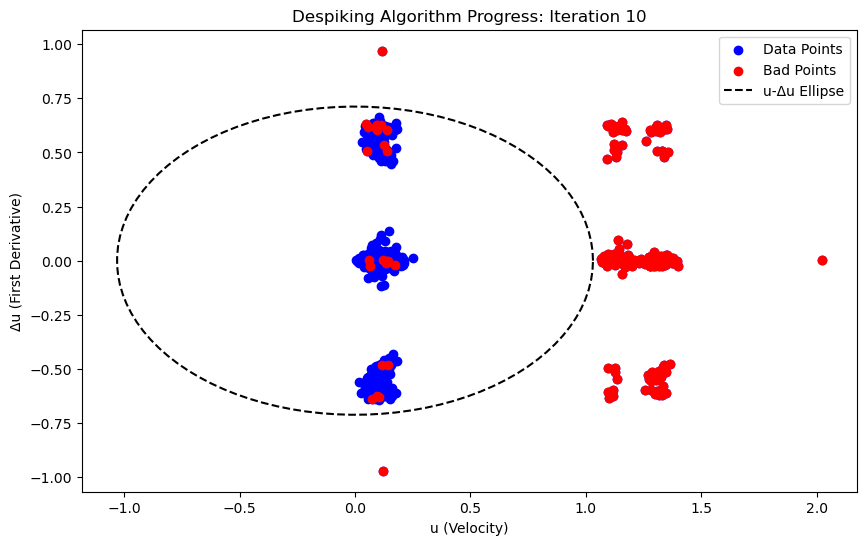

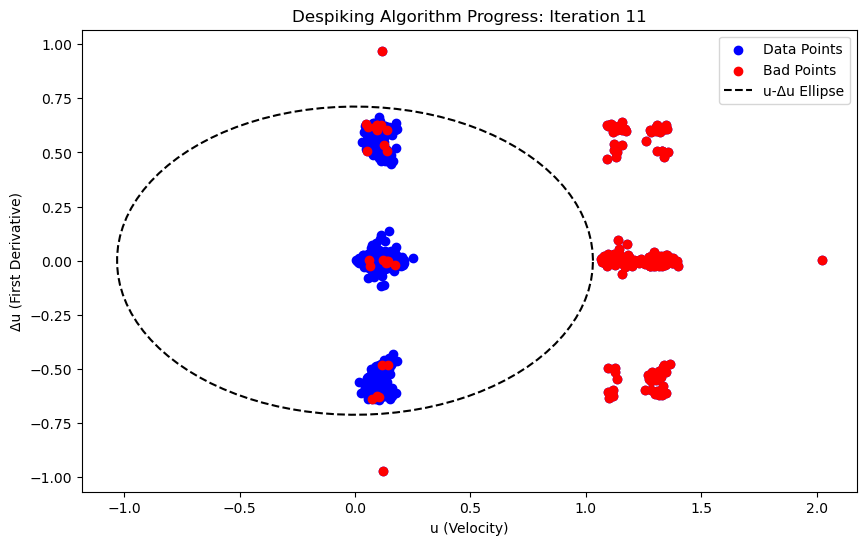

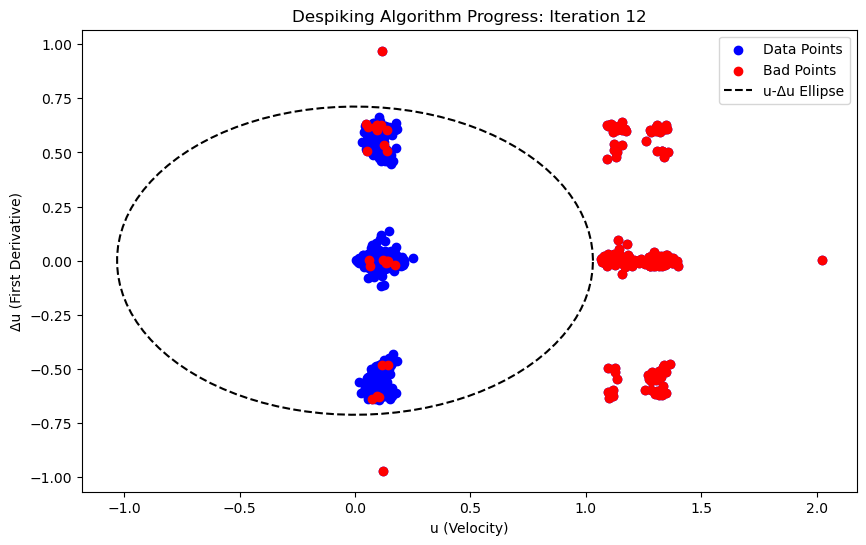

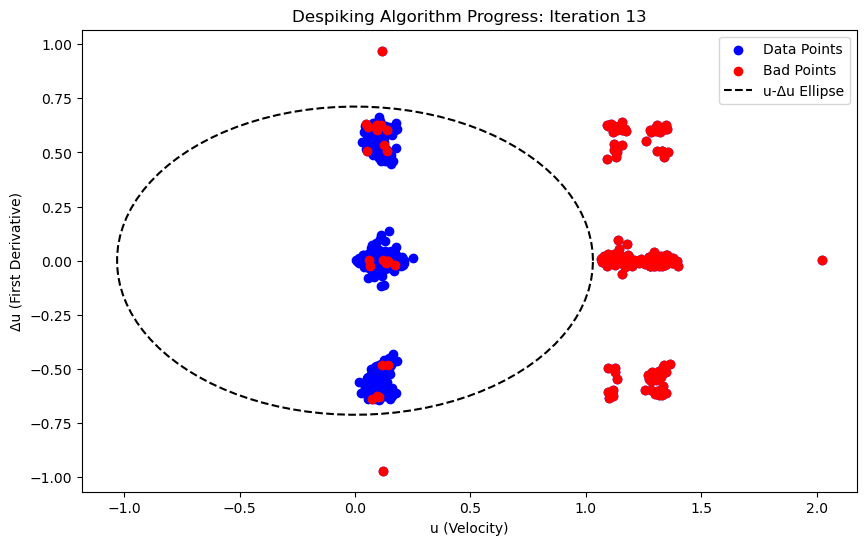

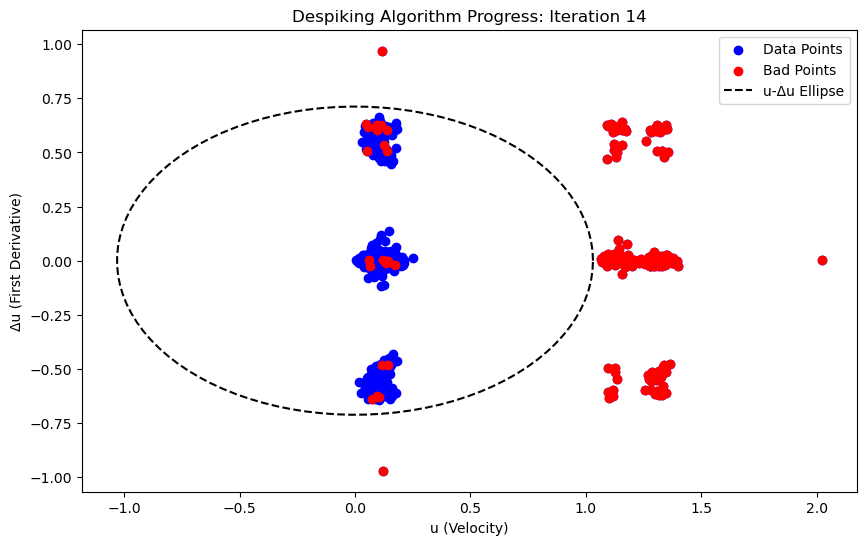

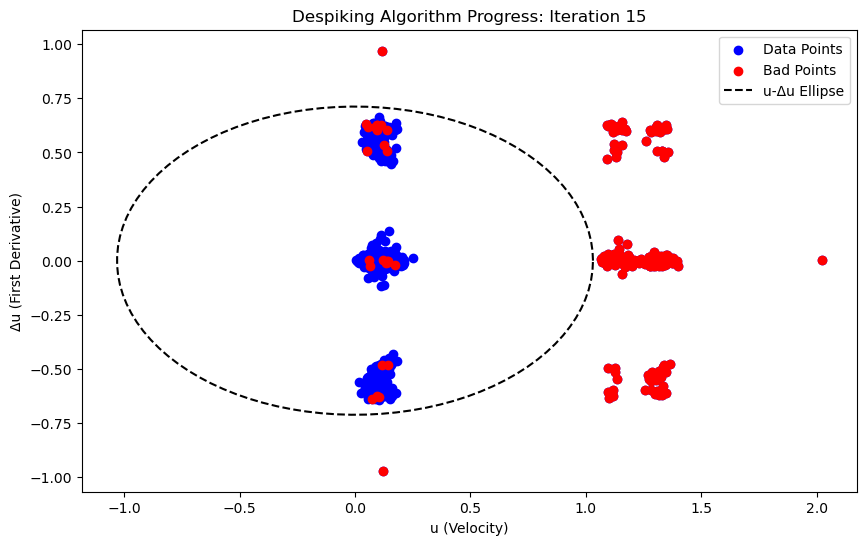

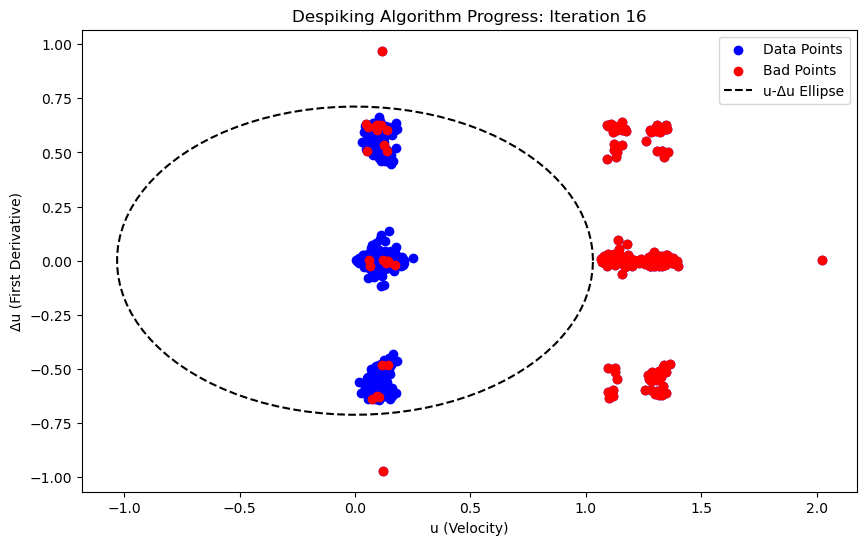

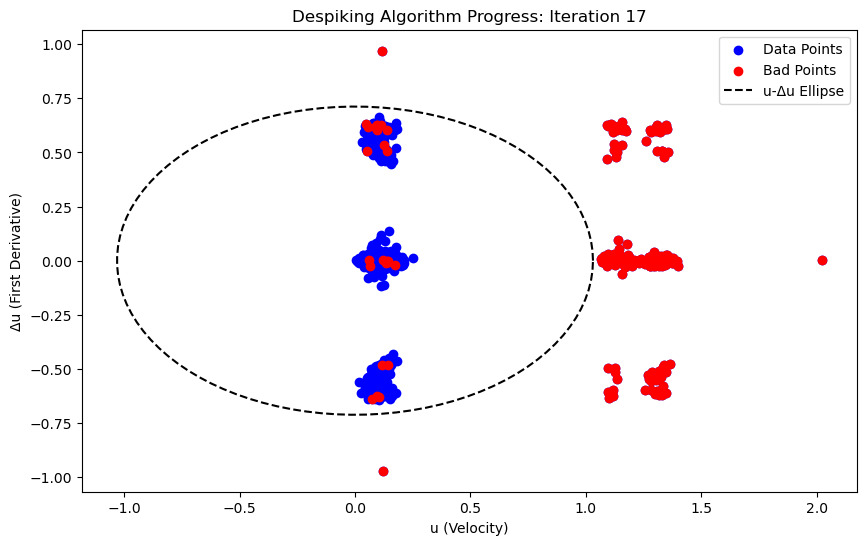

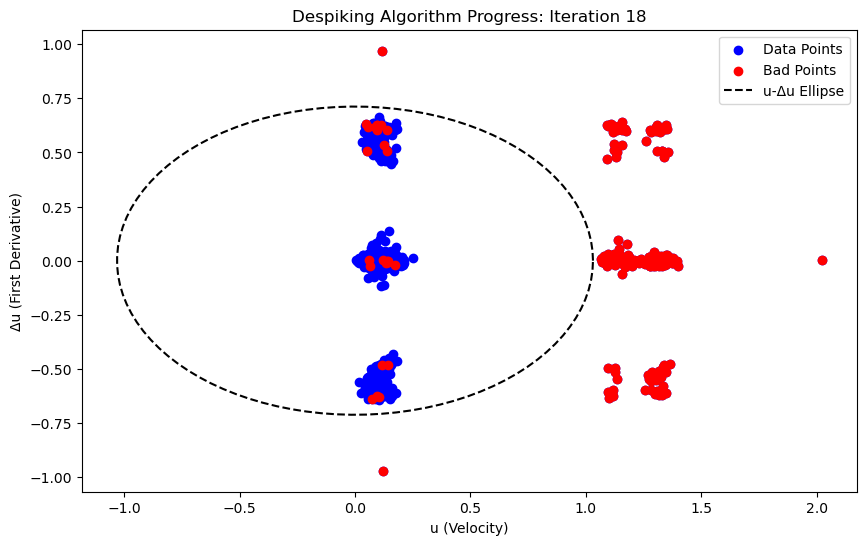

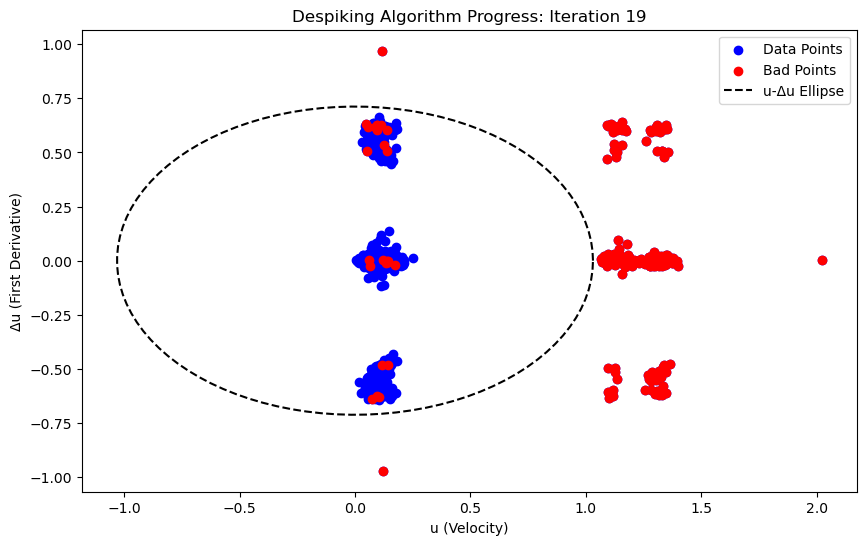

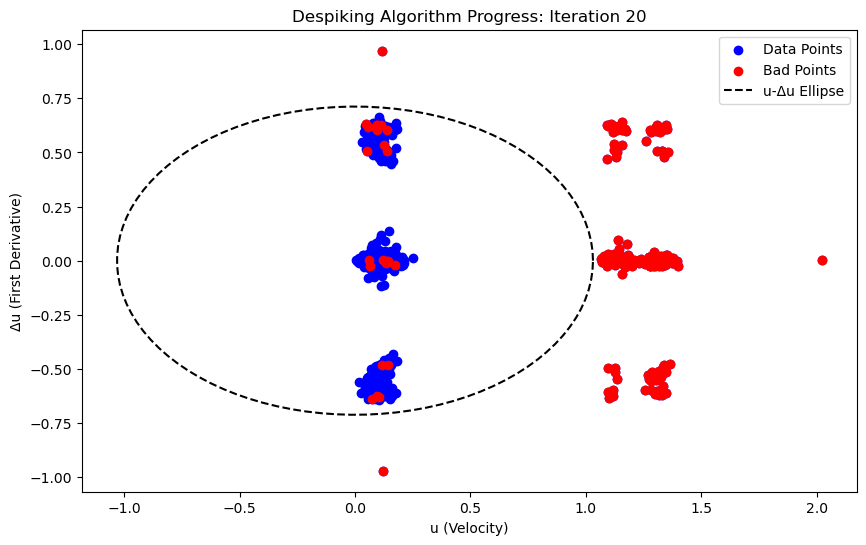

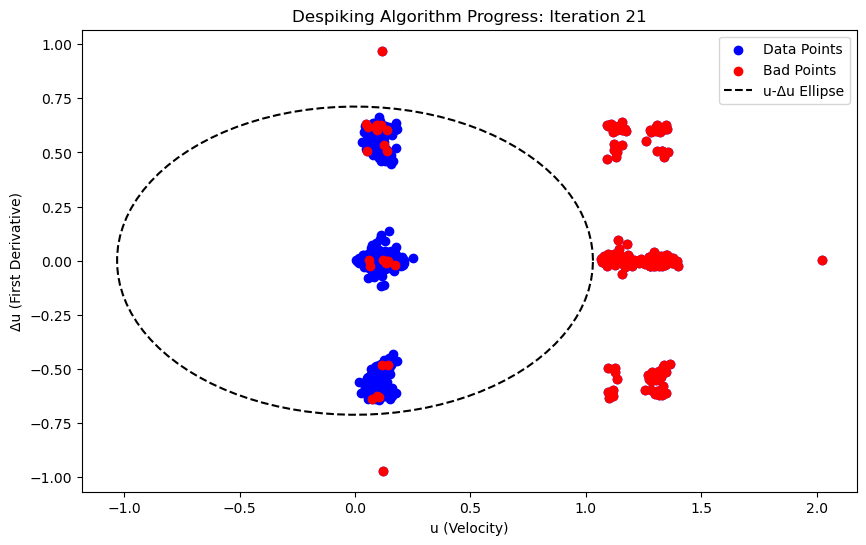

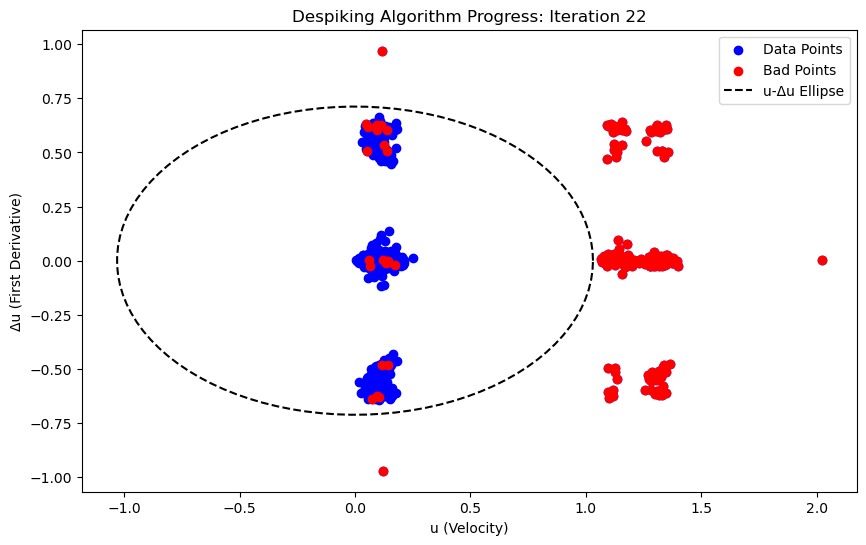

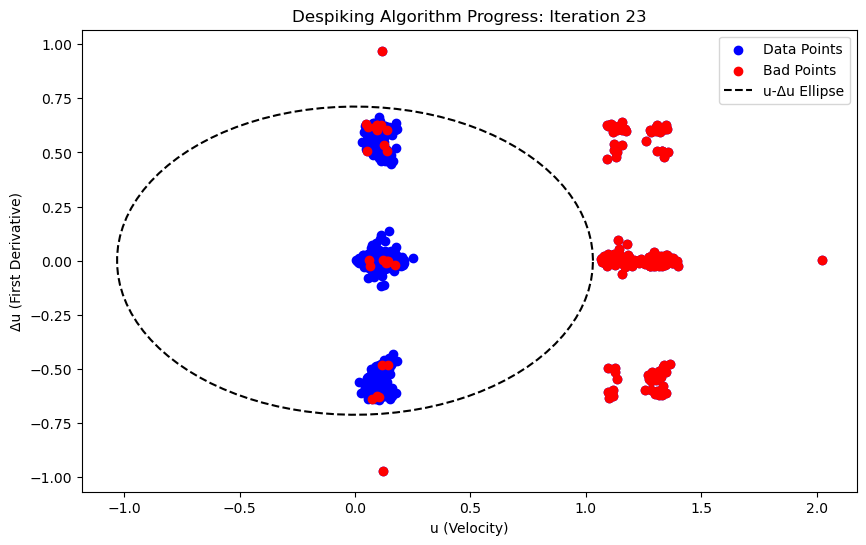

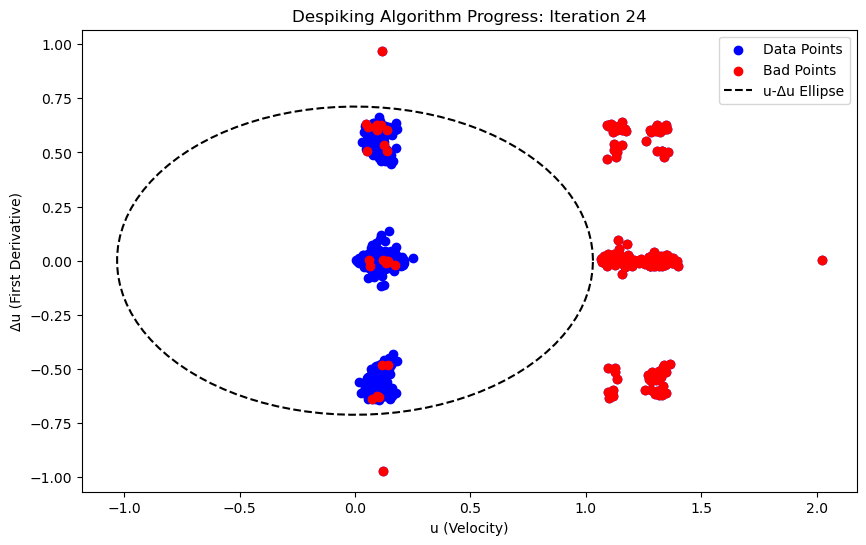

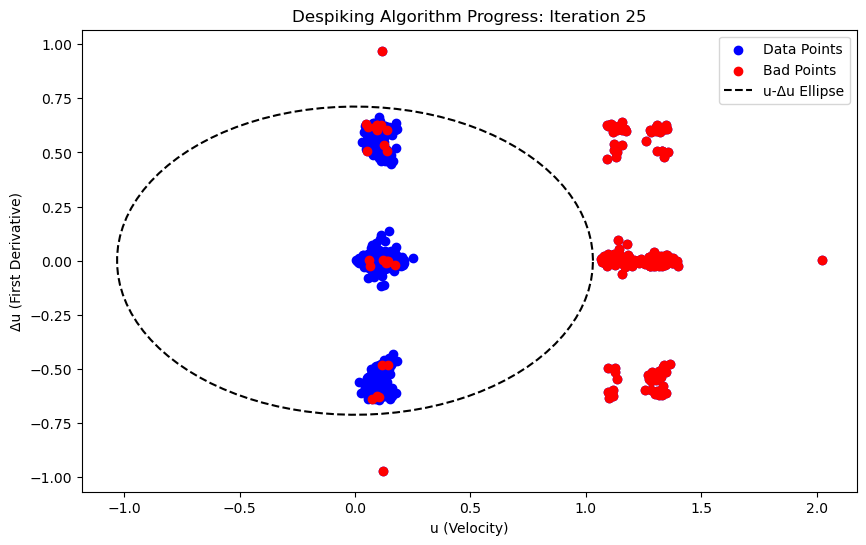

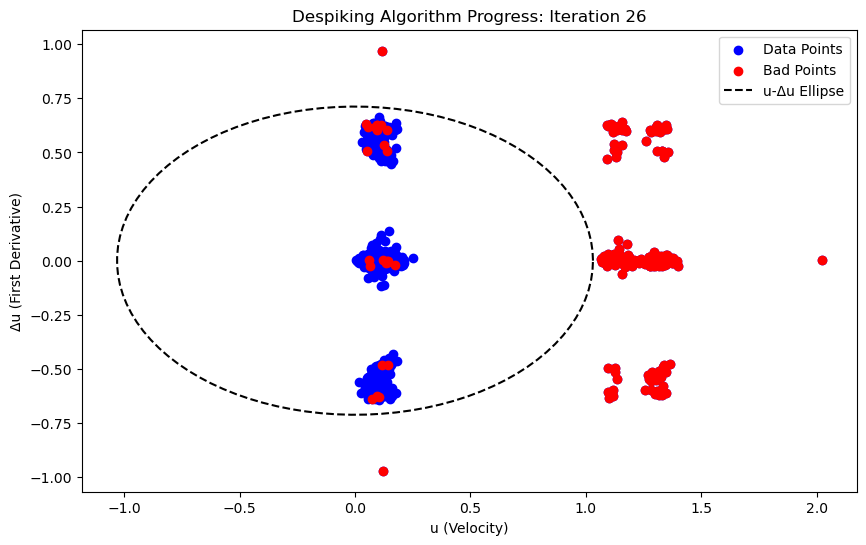

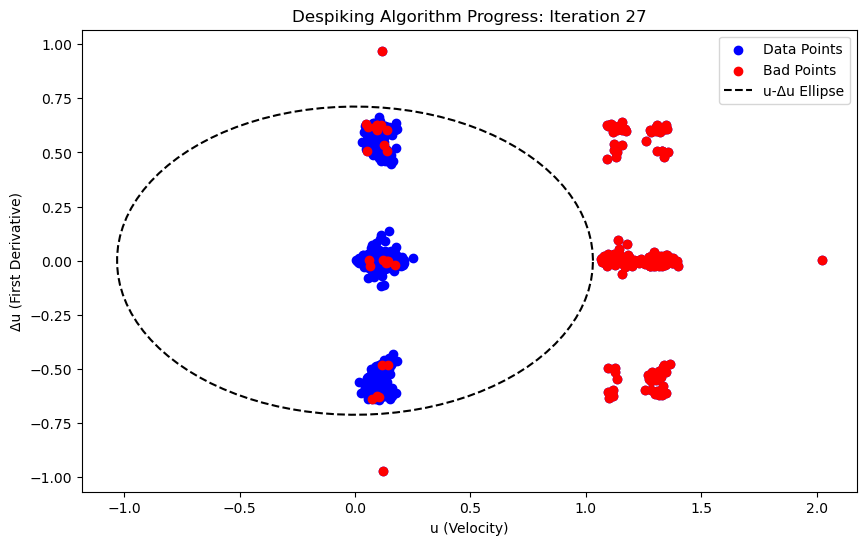

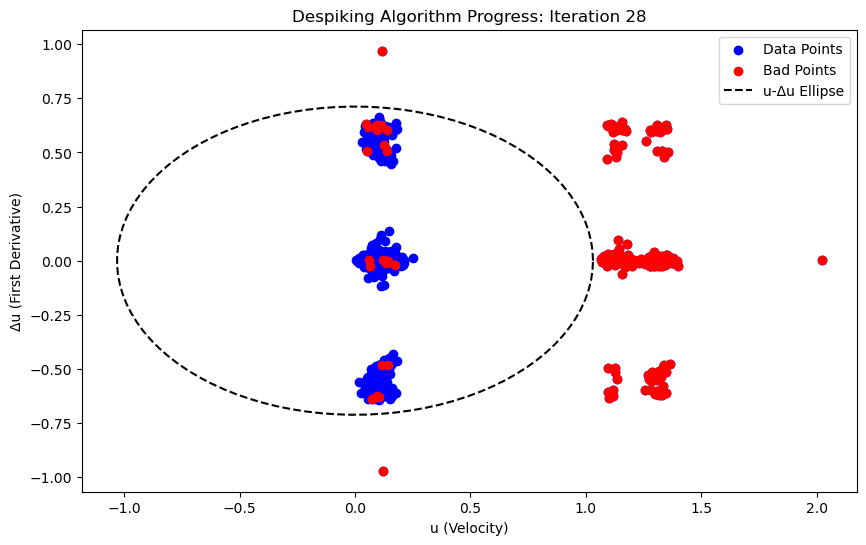

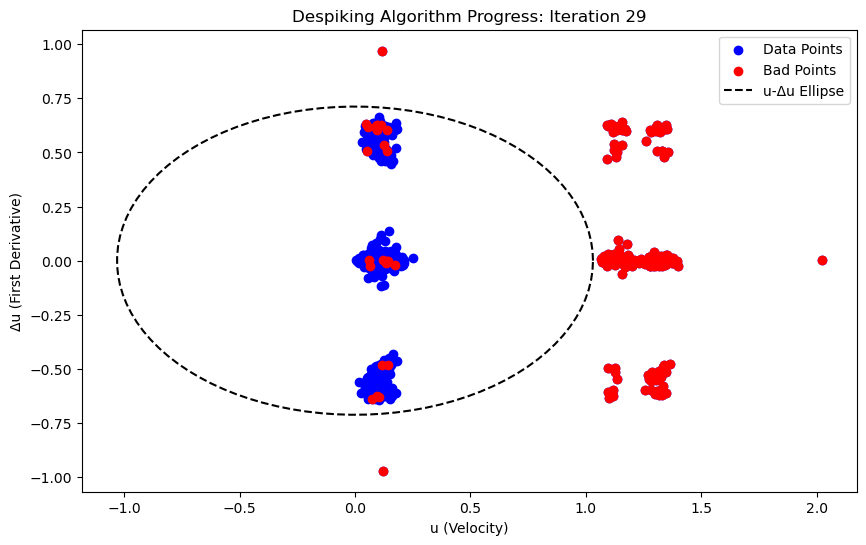

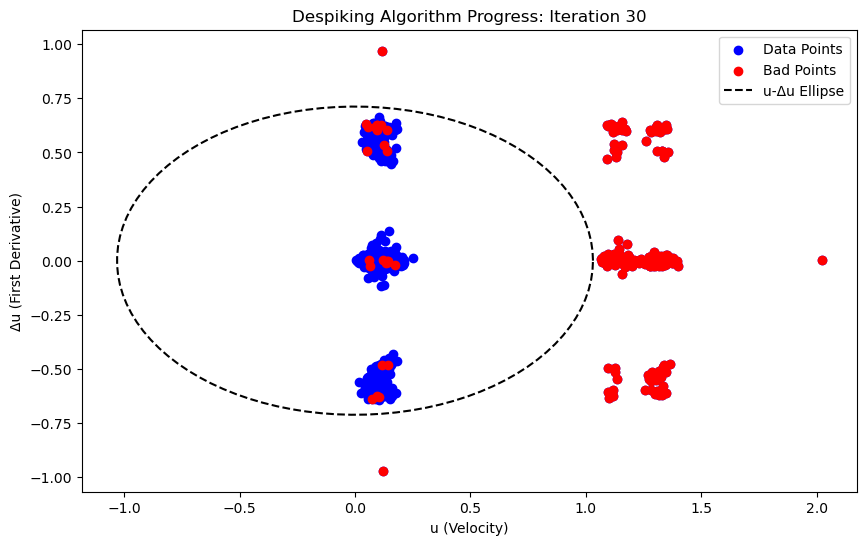

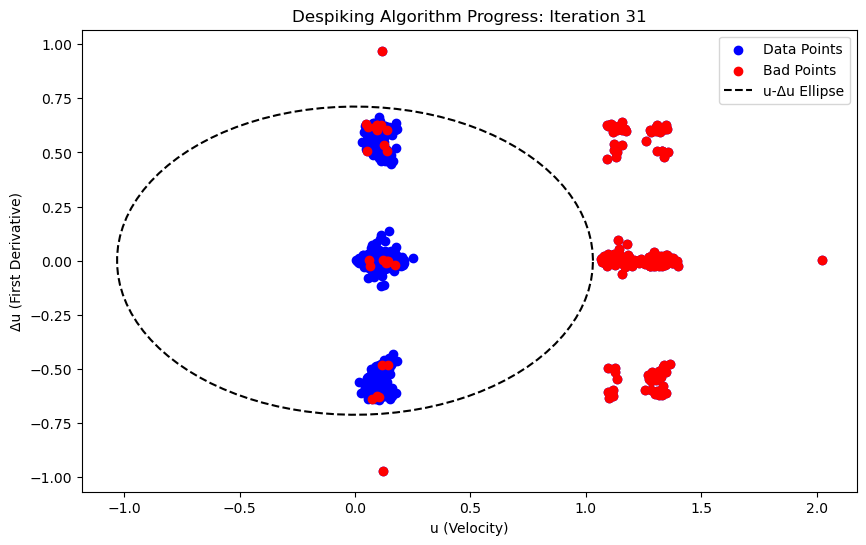

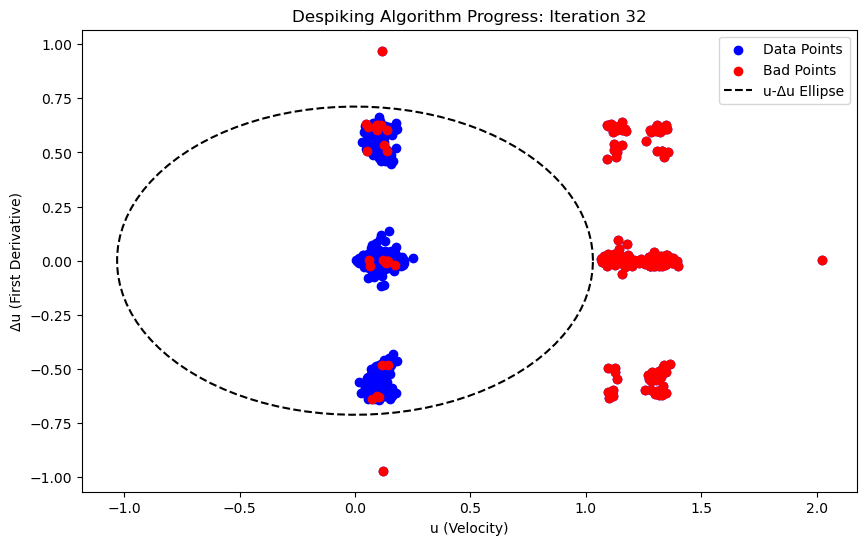

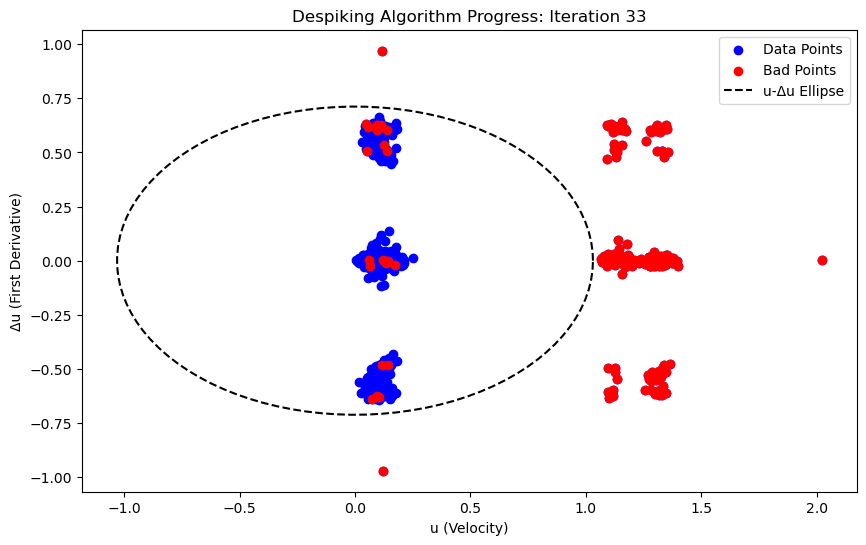

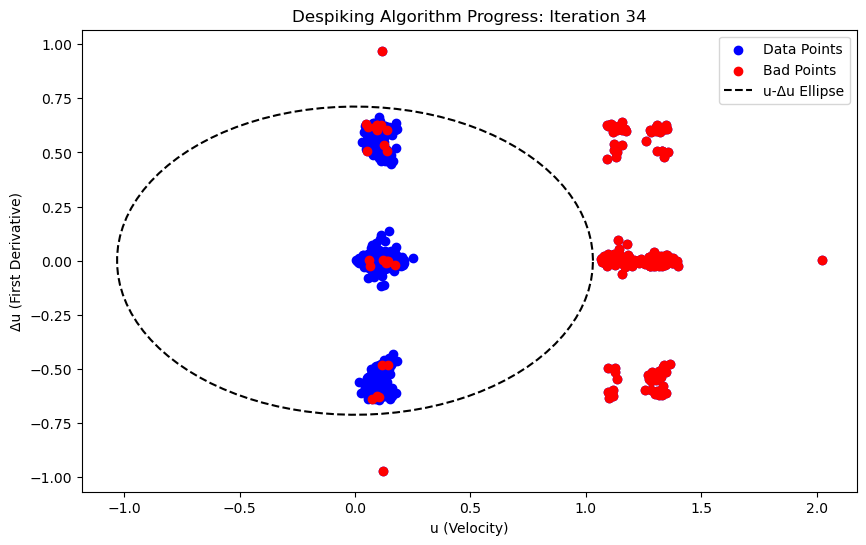

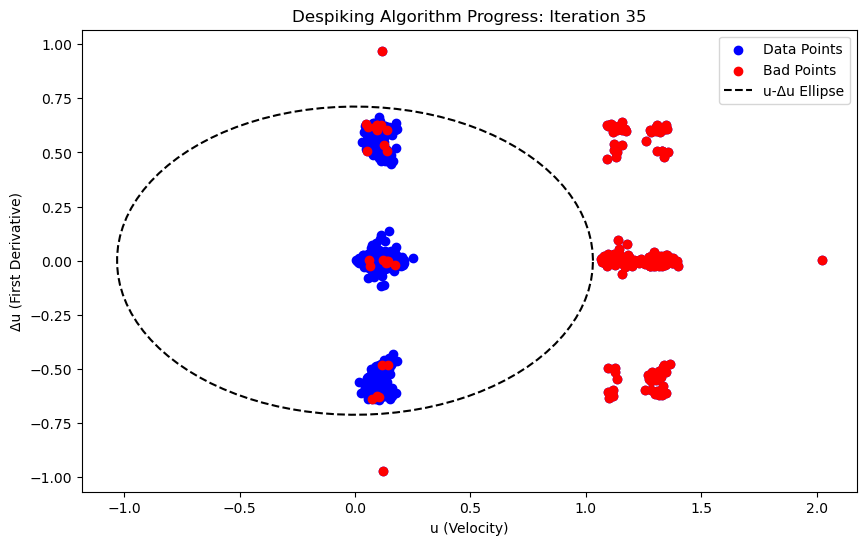

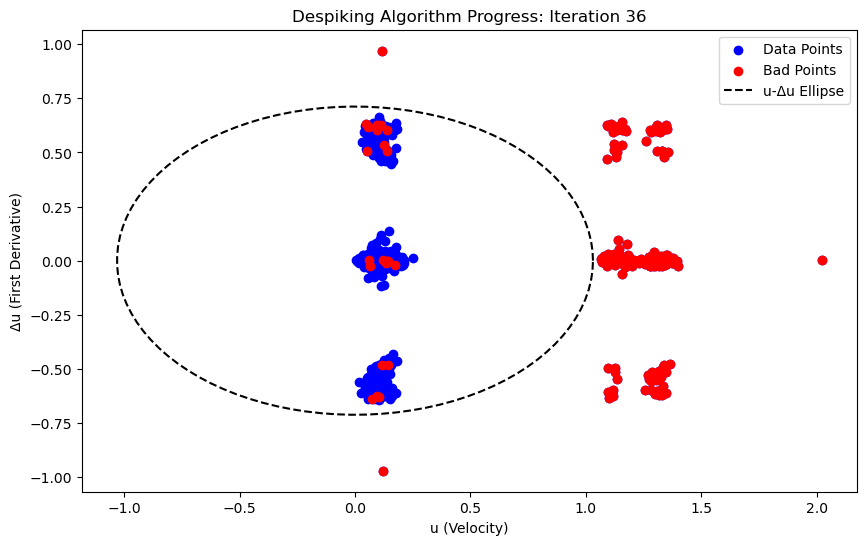

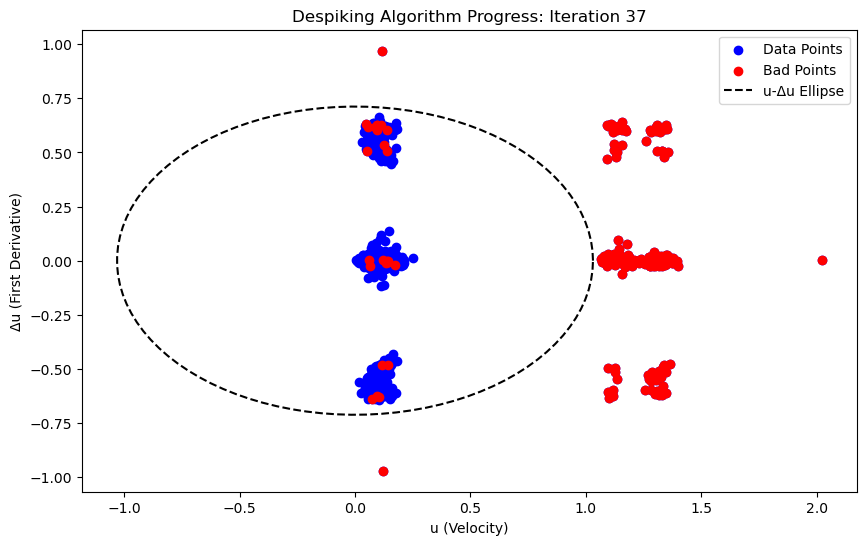

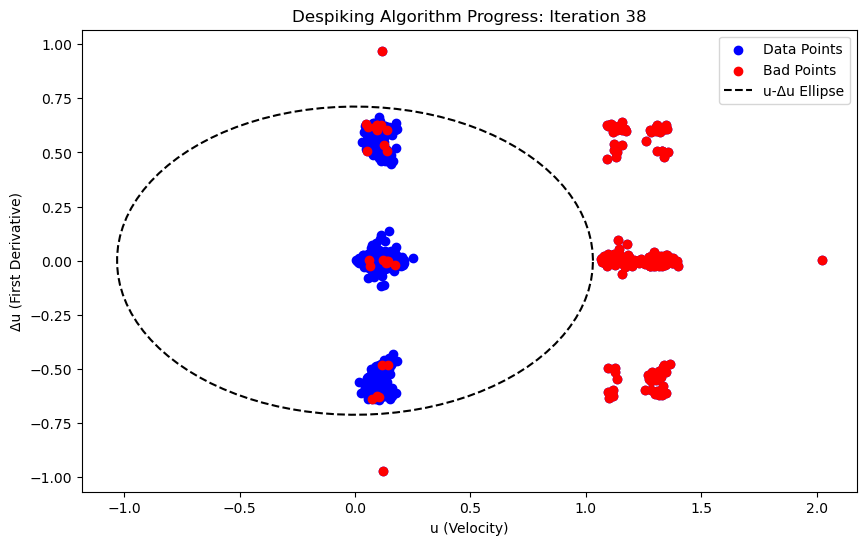

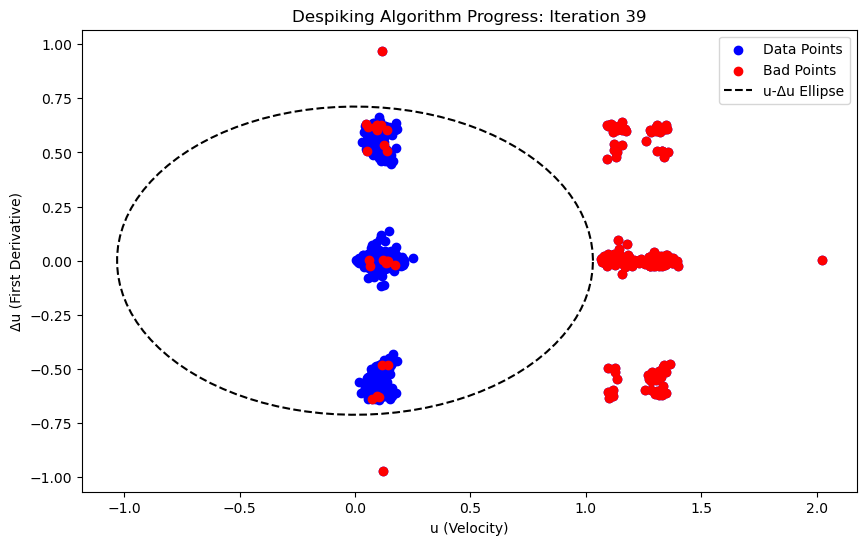

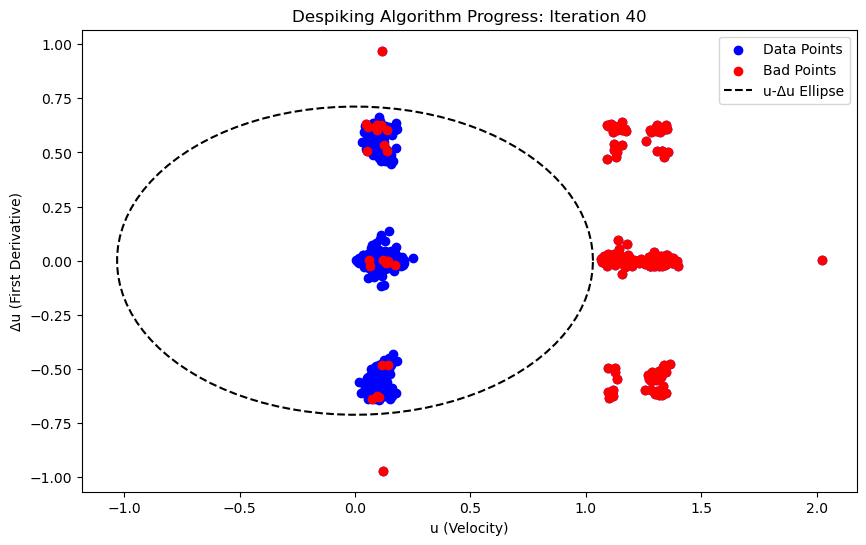

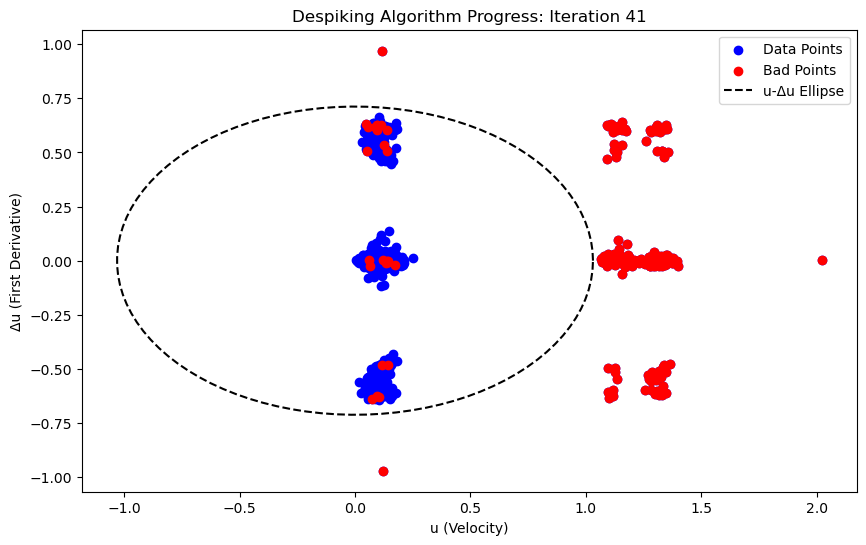

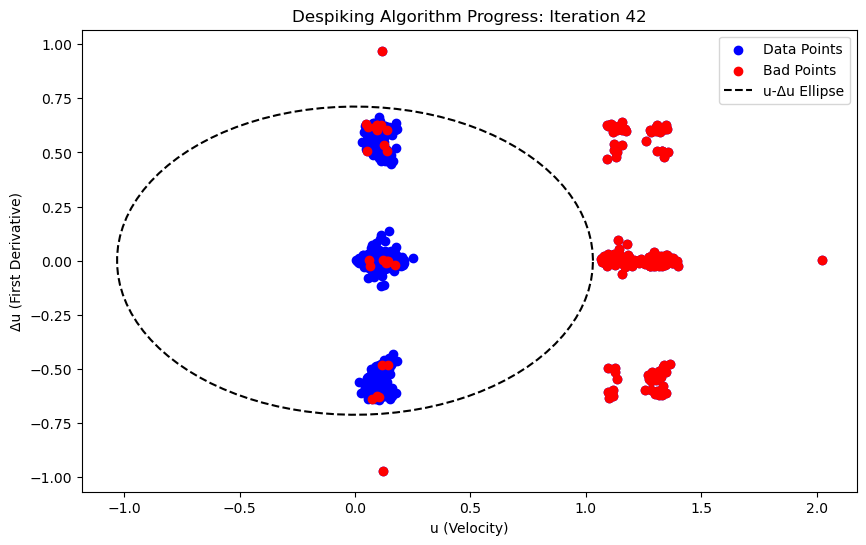

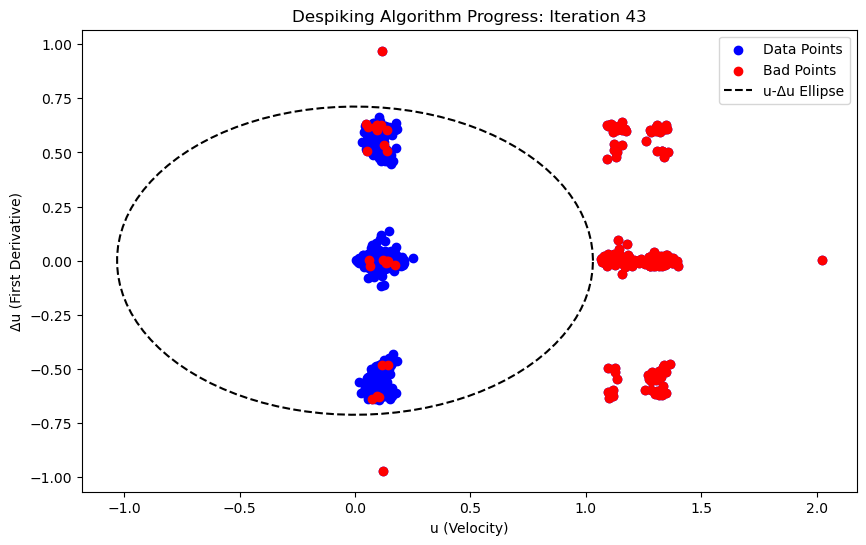

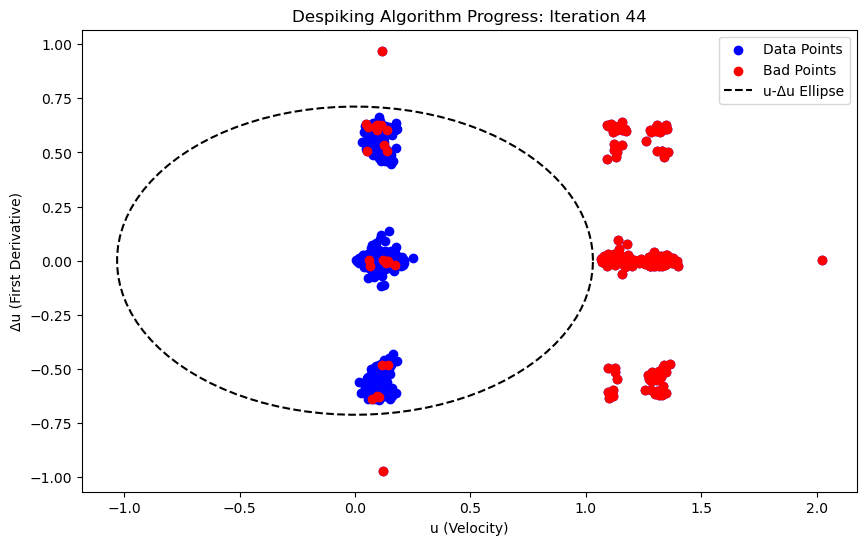

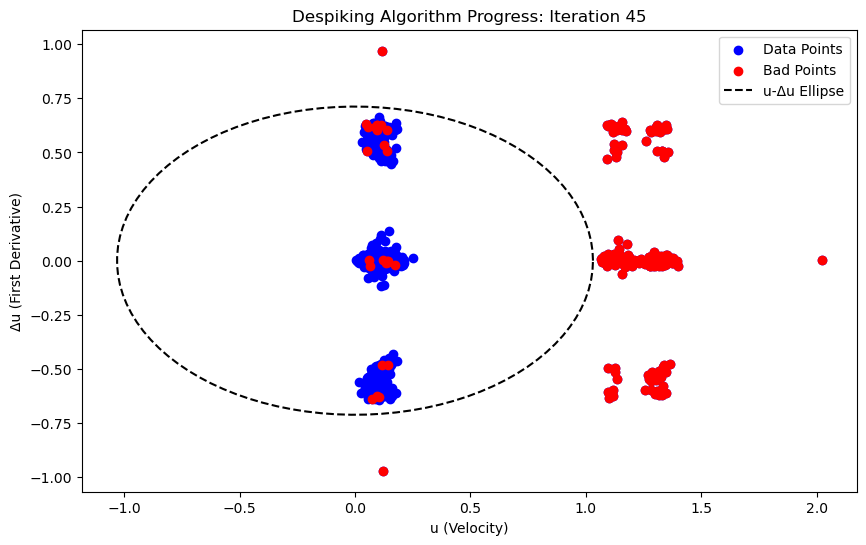

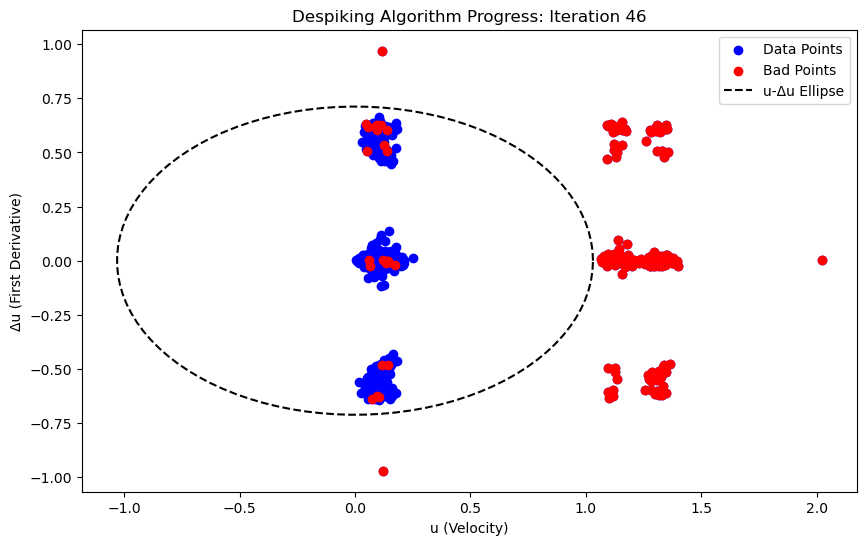

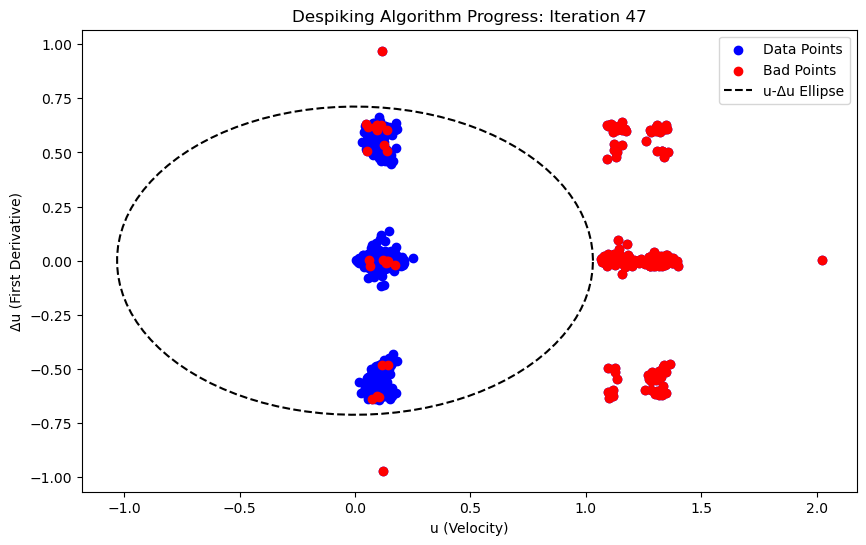

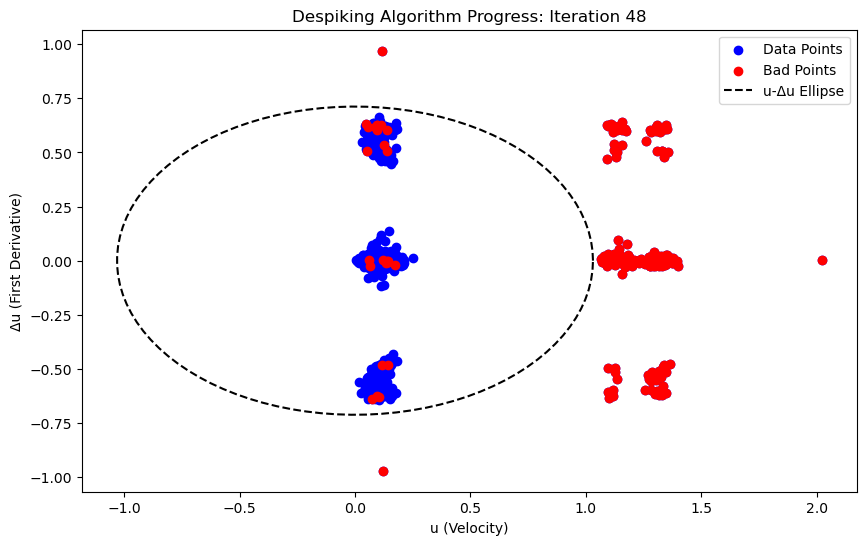

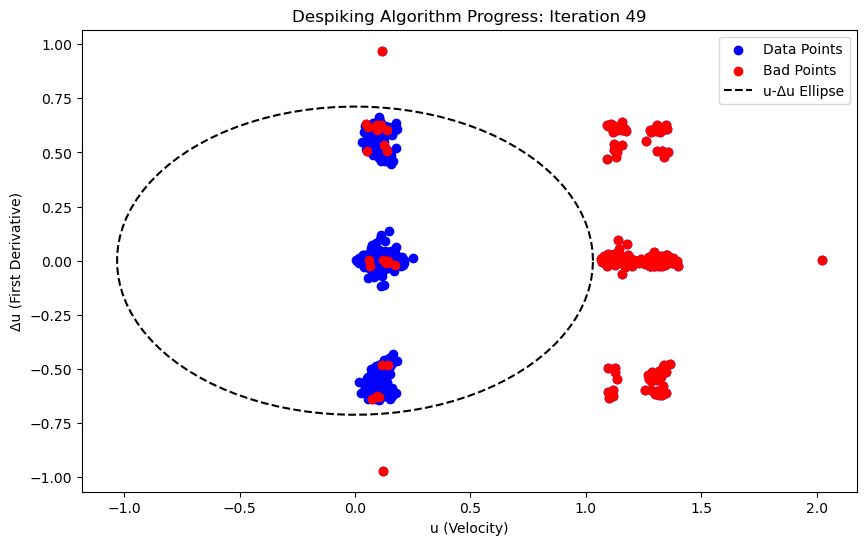

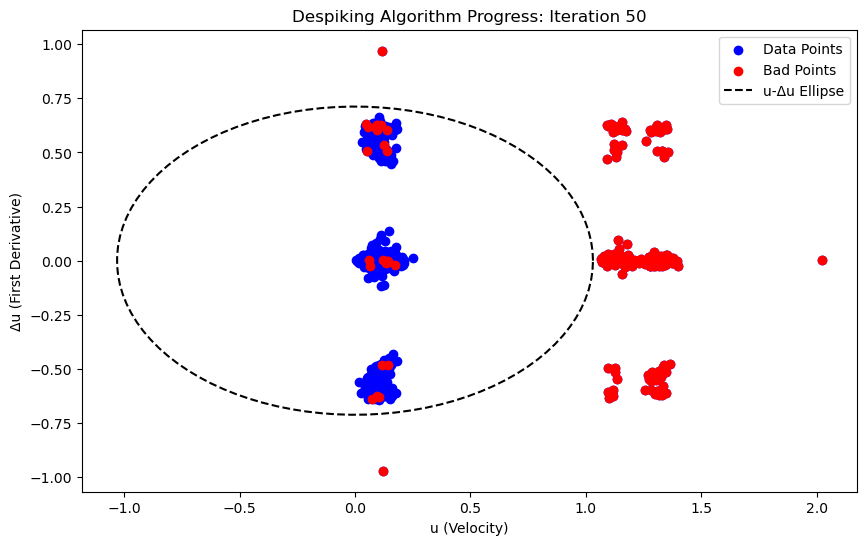

Maximum iterations reached with 351 bad indices remaining.


In [24]:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Calculate ellipse axes
adv_data.calculate_ellipse_axes()

# Run the iterative despiking process
adv_data.iterate_despiking(max_iterations=50, tolerance=5)


In [14]:
def apply_despiking(self):
    """Set bad velocity values to NaN and impute them."""
    # Copy the current filtered data (if it exists) or use the original velocity
    if hasattr(self, 'u_filtered_despiked'):
        u_current = self.u_filtered_despiked
    else:
        u_current = np.copy(self.u)
    
    # Set bad indices to NaN in the filtered data
    u_current[self.bad_indices] = np.nan

    # Interpolate over NaN values using linear interpolation
    u_current = pd.Series(u_current).interpolate(method='linear').to_numpy()
    
    # Update the filtered velocity data for the next iteration
    self.u_filtered_despiked = u_current


In [15]:
def find_bad_indices(self):
    """Find indices where data falls outside the bounds of ellipses."""
    if hasattr(self, 'u_filtered_despiked'):
        u_current = self.u_filtered_despiked
    else:
        u_current = self.u

    dU_current = np.gradient(u_current)  # Recalculate derivatives
    d2U_current = np.gradient(dU_current)  # Second derivative

    U_mean = np.mean(u_current)
    dU_mean = np.mean(dU_current)
    d2U_mean = np.mean(d2U_current)
    
    # Check for bad indices for u-Δu ellipse
    bad_u_dU = (((u_current - U_mean)**2) / self.a1**2) + (((dU_current - dU_mean)**2) / self.b1**2) > 1
    
    theta = np.arctan2(u_current, d2U_current)  # Rotation angle for each point
    bad_u_d2U = (
        ((np.cos(theta) * (u_current - U_mean) + np.sin(theta) * (d2U_current - d2U_mean))**2) / self.a2**2
        + ((np.sin(theta) * (u_current - U_mean) - np.cos(theta) * (d2U_current - d2U_mean))**2) / self.b2**2
    ) > 1
    
    bad_dU_d2U = (((dU_current - dU_mean)**2) / self.a3**2) + (((d2U_current - d2U_mean)**2) / self.b3**2) > 1
    
    # Combine all bad indices
    self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U


In [16]:
def plot_progress(self, iteration):
    """Plot the data points and the ellipses."""
    if hasattr(self, 'u_filtered_despiked'):
        u_to_plot = self.u_filtered_despiked
    else:
        u_to_plot = self.u
    
    plt.figure(figsize=(10, 6))
    plt.scatter(u_to_plot, self.dU, label='Data Points', color='blue')
    plt.scatter(u_to_plot[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
    
    # Plot the u-Δu ellipse (unrotated, θ = 0)
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_u_dU_x = self.a1 * np.cos(theta)
    ellipse_u_dU_y = self.b1 * np.sin(theta)
    plt.plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
    
    plt.xlabel('u (Velocity)')
    plt.ylabel('Δu (First Derivative)')
    plt.title(f'Despiking Algorithm Progress: Iteration {iteration}')
    plt.legend()
    plt.show()


C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9184\652231628.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.a2 = np.sqrt(a2_squared)
C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_9184\652231628.py:37: RuntimeWarning: invalid value encountered in sqrt
  self.b2 = np.sqrt(b2_squared)


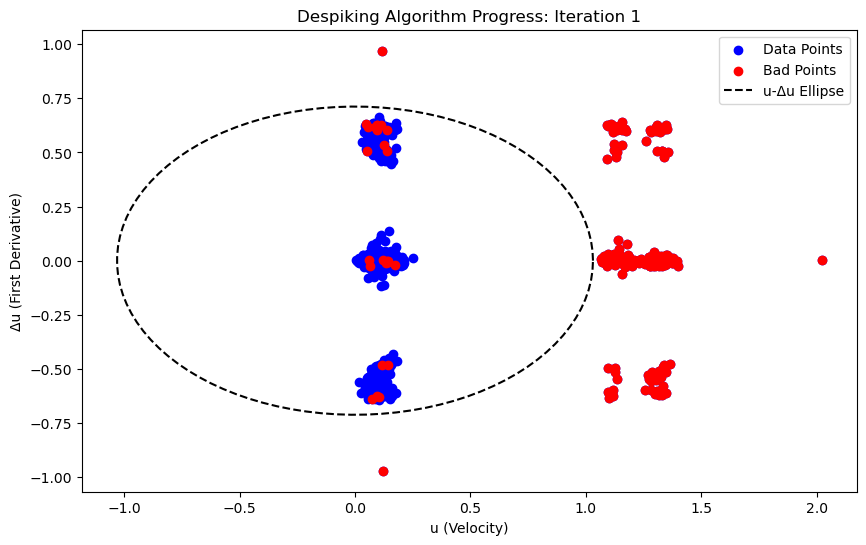

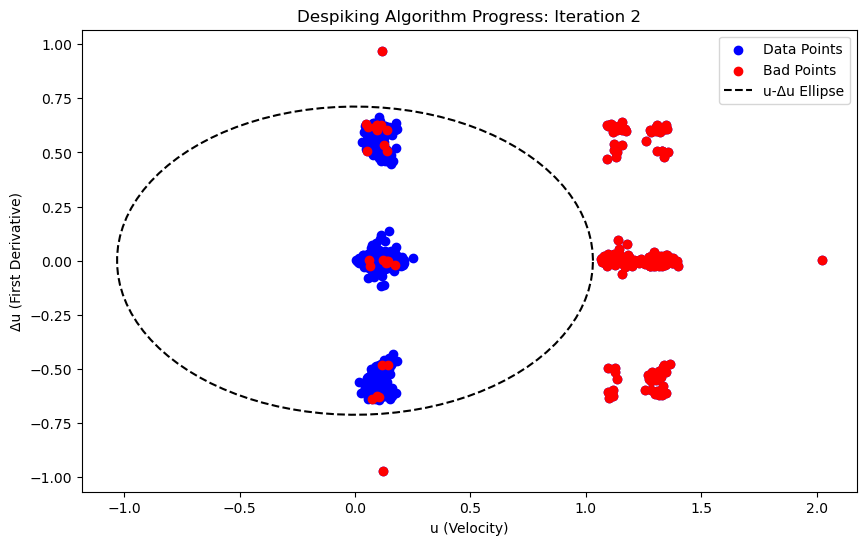

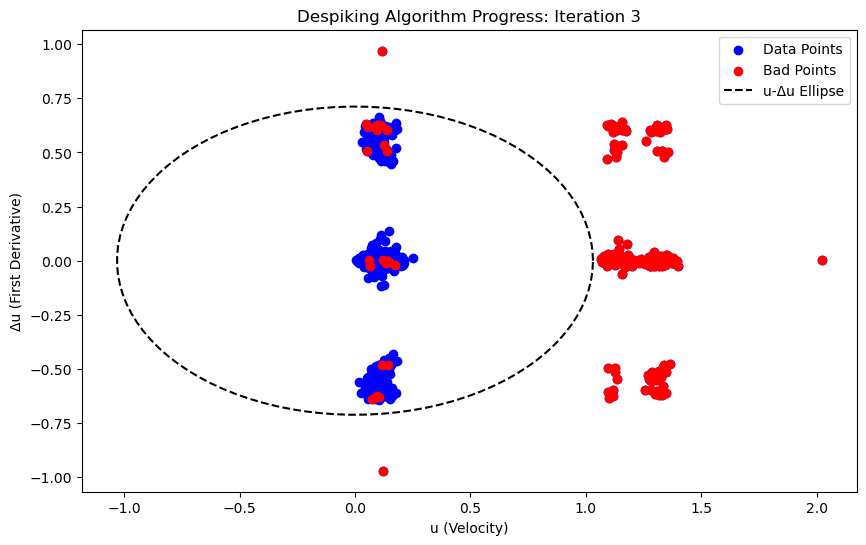

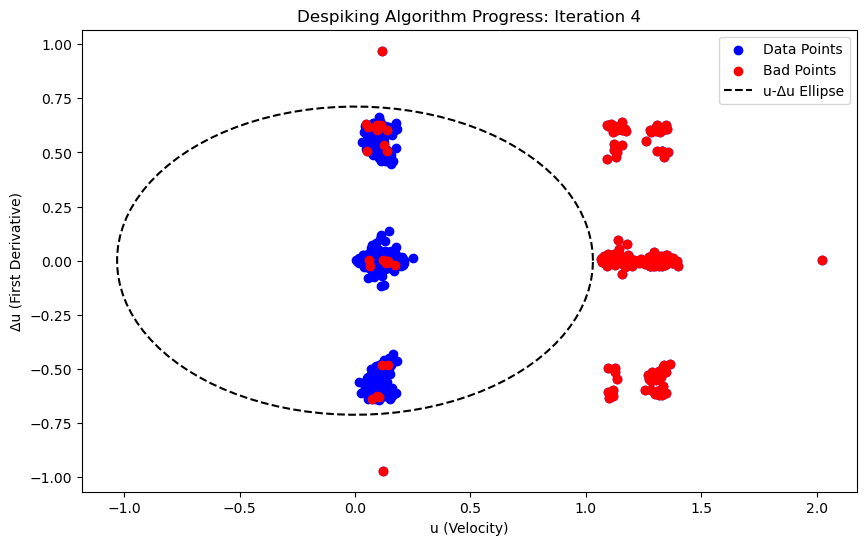

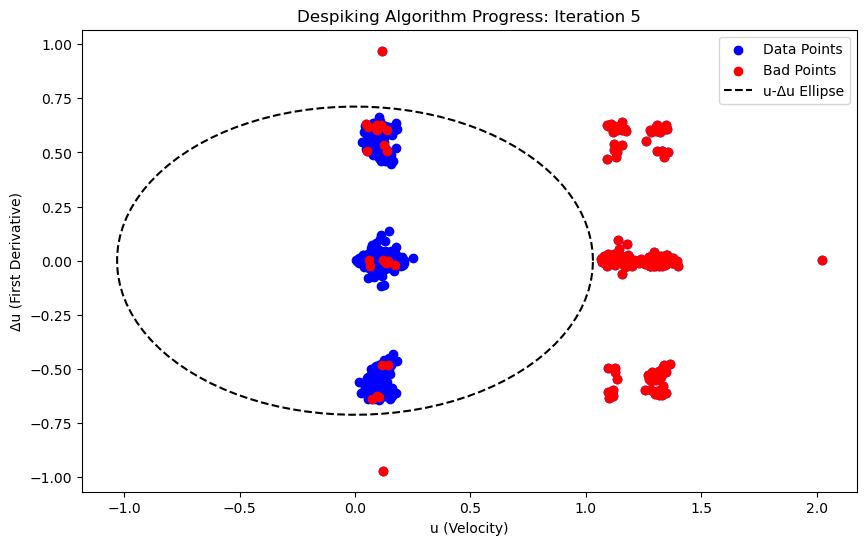

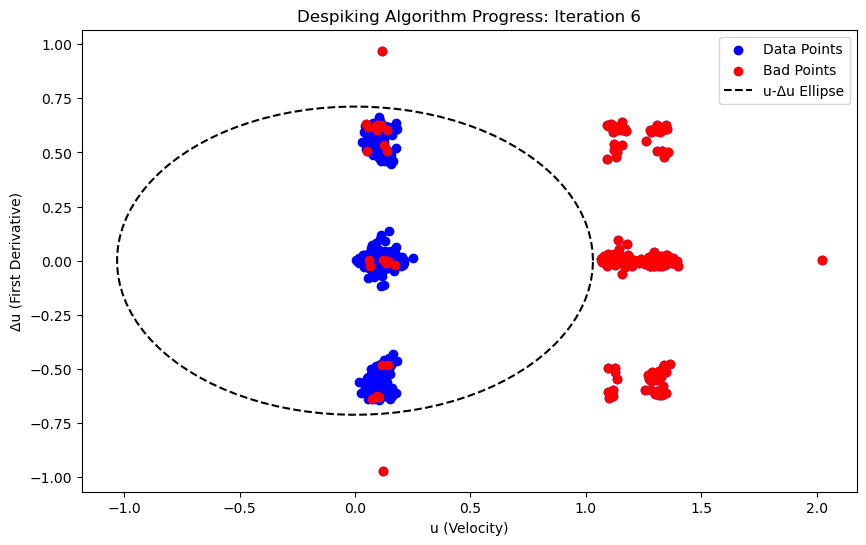

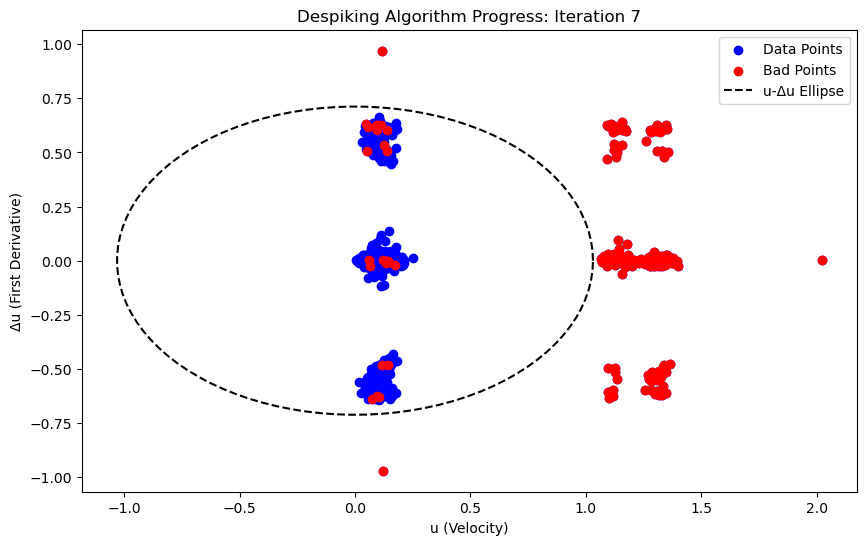

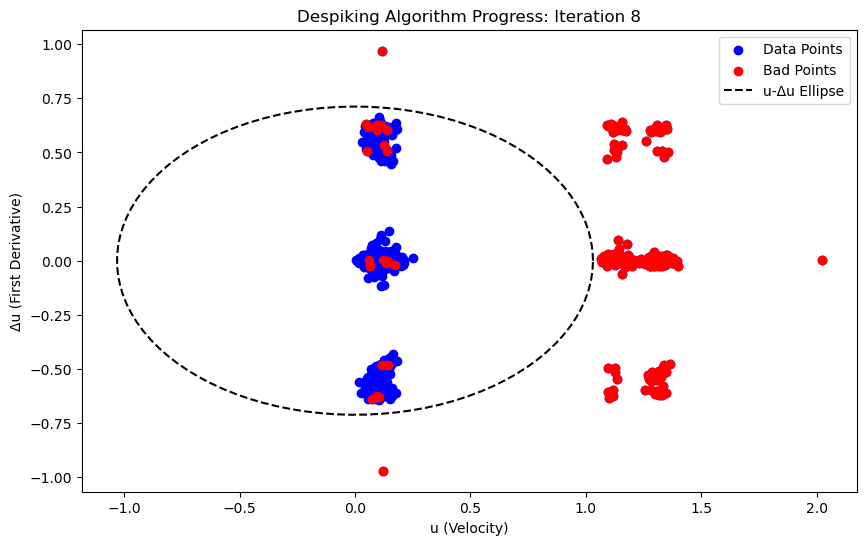

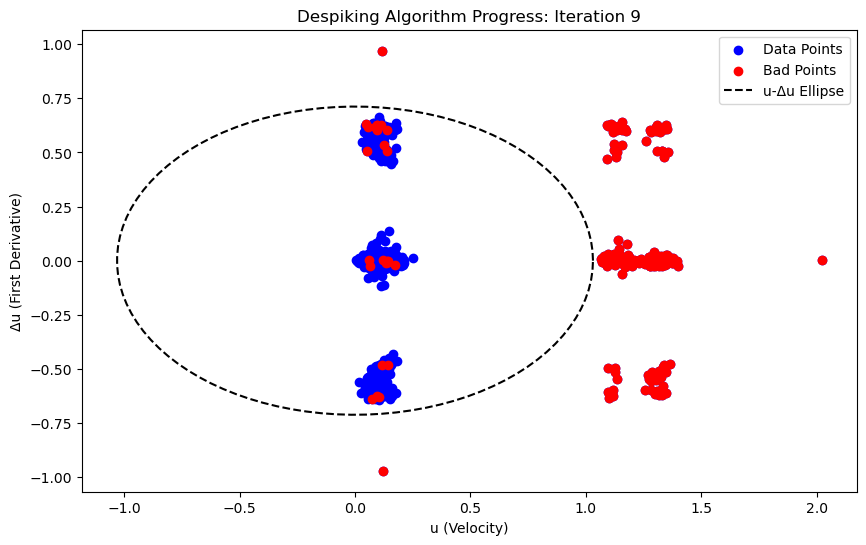

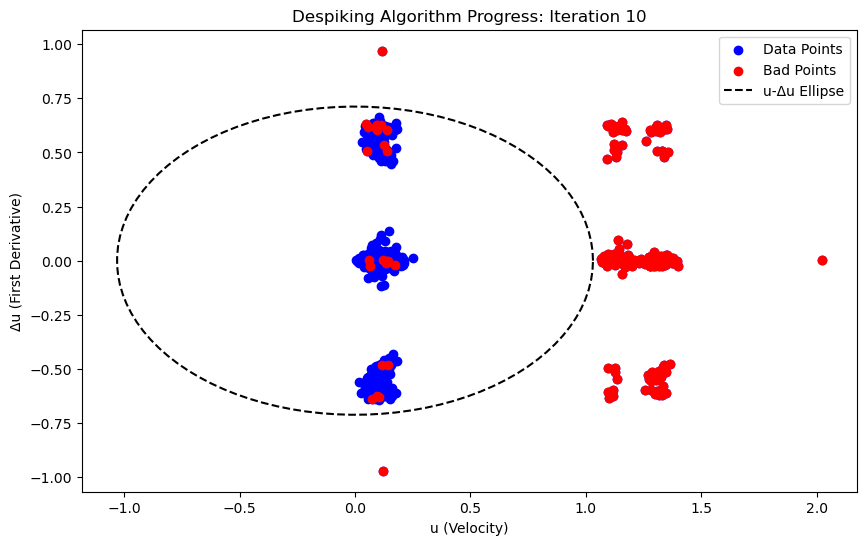

Maximum iterations reached with 351 bad indices remaining.


In [17]:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Calculate ellipse axes
adv_data.calculate_ellipse_axes()

# Run the iterative despiking process
adv_data.iterate_despiking(max_iterations=10, tolerance=5)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

class AdvData:
    def __init__(self, time, velocity):
        self.time = time
        self.u = velocity
        self.u_filtered_gn = None

    def despike_gn(self, max_iterations=10, tolerance=5):
        u = self.u.copy()
        n = len(u)

        # Helper function to calculate the ellipse boundary
        def in_ellipse(x, y, a, b, theta, x_mean, y_mean):
            cos_t, sin_t = np.cos(theta), np.sin(theta)
            x_centered, y_centered = x - x_mean, y - y_mean
            term1 = ((cos_t * x_centered + sin_t * y_centered) / a) ** 2
            term2 = ((sin_t * x_centered - cos_t * y_centered) / b) ** 2
            return term1 + term2 <= 1

        # Calculate derivatives
        for iteration in range(max_iterations):
            delta_u = np.gradient(u, self.time)
            delta2_u = np.gradient(delta_u, self.time)

            # Standard deviations
            sigma_u = np.std(u)
            sigma_delta_u = np.std(delta_u)
            sigma_delta2_u = np.std(delta2_u)

            # Scaling factor
            lambda_ = np.sqrt(2 * np.log(n))

            # Calculate θ for the u-Δ²u ellipse
            theta = np.arctan2(np.sum(u * delta2_u), np.sum(u ** 2))

            # Major and minor axes of ellipses
            a1, b1 = lambda_ * sigma_u, lambda_ * sigma_delta_u
            a2_sq = (lambda_ * sigma_u) ** 2
            b2_sq = (lambda_ * sigma_delta2_u) ** 2
            a3, b3 = lambda_ * sigma_delta_u, lambda_ * sigma_delta2_u

            # Solve for the rotated ellipse axes
            A = np.array([[np.cos(theta) ** 2, np.sin(theta) ** 2], 
                          [np.sin(theta) ** 2, np.cos(theta) ** 2]])
            B = np.array([a2_sq, b2_sq])
            x = np.linalg.solve(A, B)
            a2, b2 = np.sqrt(x)

            # Identify bad data points
            bad_indices = np.zeros(n, dtype=bool)
            
            # u-Δu ellipse
            bad_indices |= ~in_ellipse(u, delta_u, a1, b1, 0, np.mean(u), np.mean(delta_u))
            
            # u-Δ²u ellipse (rotated)
            bad_indices |= ~in_ellipse(u, delta2_u, a2, b2, theta, np.mean(u), np.mean(delta2_u))
            
            # Δu-Δ²u ellipse
            bad_indices |= ~in_ellipse(delta_u, delta2_u, a3, b3, 0, np.mean(delta_u), np.mean(delta2_u))

            # Stop if bad indices are below tolerance
            num_bad = np.sum(bad_indices)
            print(f"Iteration {iteration + 1}: {num_bad} bad points found.")
            
            # Plot the progress (e.g., u vs Δu, u vs Δ²u, Δu vs Δ²u)
            plt.figure(figsize=(12, 8))
            plt.subplot(3, 1, 1)
            plt.scatter(u, delta_u, c=bad_indices, cmap='coolwarm', label='Bad points')
            plt.xlabel('u (velocity)')
            plt.ylabel('Δu (velocity gradient)')
            plt.title(f'Iteration {iteration + 1} u vs Δu')

            plt.subplot(3, 1, 2)
            plt.scatter(u, delta2_u, c=bad_indices, cmap='coolwarm', label='Bad points')
            plt.xlabel('u (velocity)')
            plt.ylabel('Δ²u (second derivative of velocity)')
            plt.title(f'Iteration {iteration + 1} u vs Δ²u')

            plt.subplot(3, 1, 3)
            plt.scatter(delta_u, delta2_u, c=bad_indices, cmap='coolwarm', label='Bad points')
            plt.xlabel('Δu (velocity gradient)')
            plt.ylabel('Δ²u (second derivative of velocity)')
            plt.title(f'Iteration {iteration + 1} Δu vs Δ²u')

            plt.tight_layout()
            plt.show()

            # Interpolate over bad data points
            if num_bad < tolerance:
                break
            u[bad_indices] = np.interp(self.time[bad_indices], self.time[~bad_indices], u[~bad_indices])

        self.u_filtered_gn = u

    def plot_filtered_vs_original(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.time, self.u, label='Original Signal', color='blue', alpha=0.6)
        plt.plot(self.time, self.u_filtered_gn, label='Filtered Signal (Goring & Nikora)', color='red')
        plt.xlabel('Time')
        plt.ylabel('Velocity')
        plt.title('Original vs. Filtered Signal')
        plt.legend()
        plt.show()

# Usage example
# adv = AdvData(time_array, velocity_array)
# adv.despike_gn()
# adv.plot_filtered_vs_original()
